In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu
from sklearn.metrics import (
   confusion_matrix, ConfusionMatrixDisplay,
   roc_curve, auc,
   precision_recall_curve, average_precision_score
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
symbol = "BTCUSDT"
if not Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

df = pd.read_csv(file_path, parse_dates=['Time'])

df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
lst_input = ["VPIN", "Roll", "RollImpact", "KyleLambda", "AmihudLambda", "CDF"]
list_output = ["SpreadChangeSign", "RealizedVolatilitySign", "JB_ChangeSign", "AR_ChangeSign", "SkewnessSign", "KurtosisSign", "ReturnsSign", "MASign"]

# Khảo sát bộ data

In [4]:
# Chỉ giữ lại các cột cần dùng
df = df[lst_input + list_output]

In [5]:
df.shape

(310, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VPIN                    261 non-null    float64
 1   Roll                    259 non-null    float64
 2   RollImpact              259 non-null    float64
 3   KyleLambda              260 non-null    float64
 4   AmihudLambda            260 non-null    float64
 5   CDF                     261 non-null    float64
 6   SpreadChangeSign        260 non-null    float64
 7   RealizedVolatilitySign  210 non-null    float64
 8   JB_ChangeSign           210 non-null    float64
 9   AR_ChangeSign           210 non-null    float64
 10  SkewnessSign            210 non-null    float64
 11  KurtosisSign            210 non-null    float64
 12  ReturnsSign             259 non-null    float64
 13  MASign                  310 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.

- Bộ dữ liệu có những dòng dữ liệu null do quá trình tính toán bằng rolling

In [7]:
# Xóa những dòng có giá trị null
df = df.dropna()
df.shape

(210, 14)

# PHÂN TÍCH BIẾN ĐẦU VÀO

### Thống kê mô tả của các biến đầu vào cho mô hình

In [8]:
pd.DataFrame(df[lst_input].describe()).T

count          mean           std           min           25%  \
VPIN          210.0  1.846641e-01  2.386893e-02  1.434474e-01  1.642412e-01   
Roll          210.0  1.320289e+02  6.044284e+01  3.075790e+01  8.227209e+01   
RollImpact    210.0  4.652456e-06  2.134005e-06  1.080116e-06  2.904901e-06   
KyleLambda    210.0 -6.060856e+12  3.461206e+14 -2.533817e+15 -5.718458e-01   
AmihudLambda  210.0  1.050525e+07  2.065119e+06  7.821546e+06  8.412725e+06   
CDF           210.0  4.537858e-01  2.917812e-01  3.831418e-03  2.040230e-01   

                       50%           75%           max  
VPIN          1.796206e-01  2.085980e-01  2.267901e-01  
Roll          1.171351e+02  1.769649e+02  2.506166e+02  
RollImpact    4.124040e-06  6.240959e-06  8.853141e-06  
KyleLambda   -4.573778e-01 -3.457827e-01  3.323406e+15  
AmihudLambda  1.015007e+07  1.244262e+07  1.463969e+07  
CDF           4.042146e-01  7.116858e-01  9.885057e-01

### Biểu đồ phân bố của VPIN

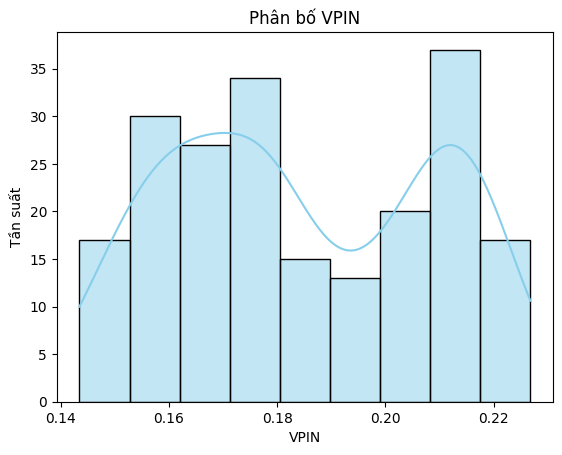

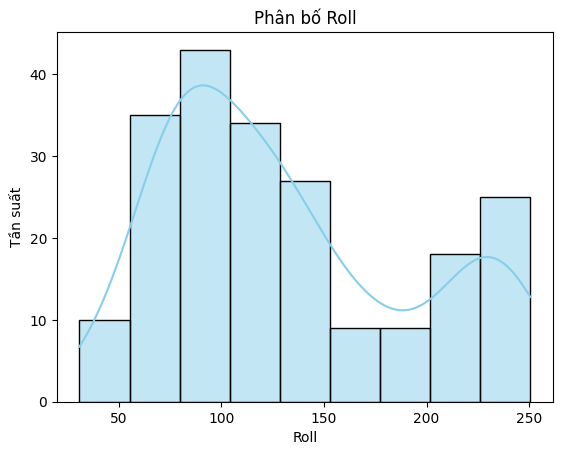

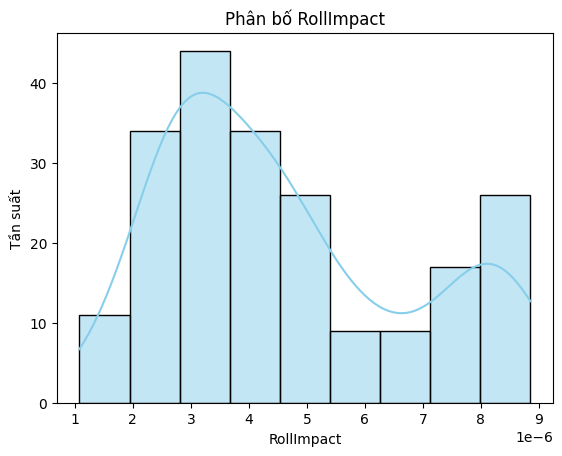

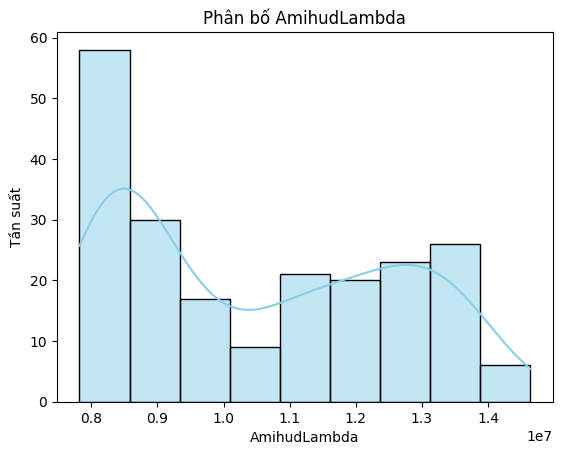

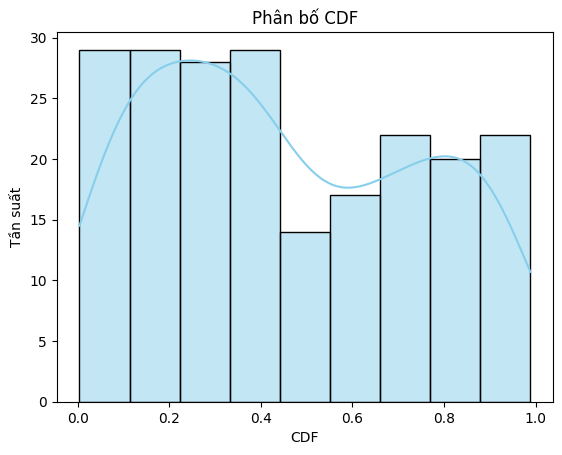

In [9]:
for col in lst_input:
    try:
        plt.Figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Phân bố {col}')
        plt.xlabel(col)
        plt.ylabel('Tần suất')
        plt.show()
    except:
        pass

### Vẽ biểu đồ hộp - Boxplot của VPIN

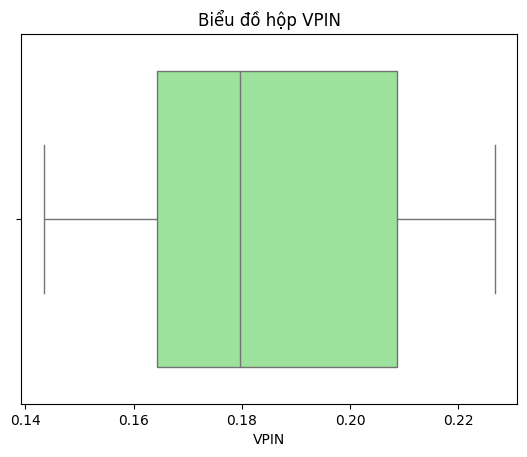

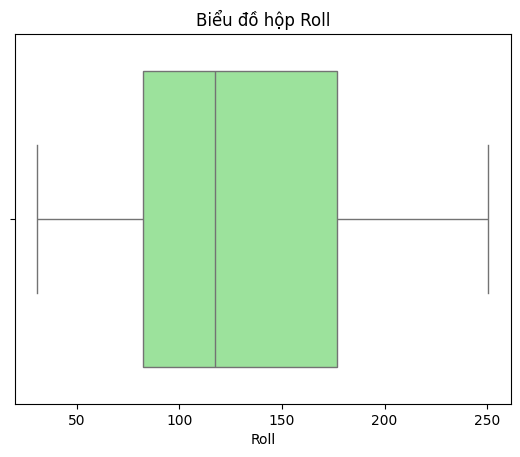

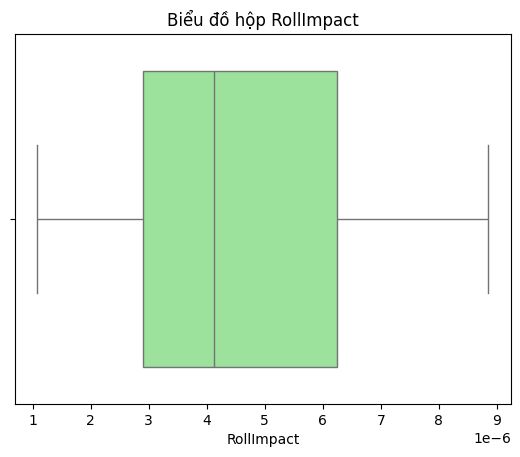

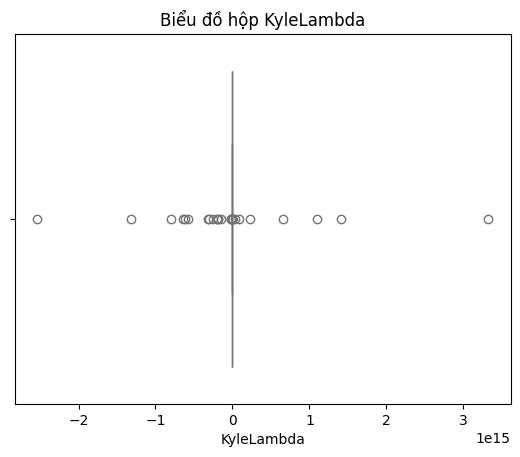

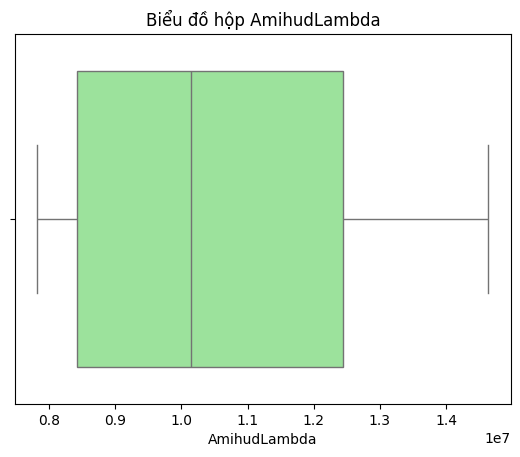

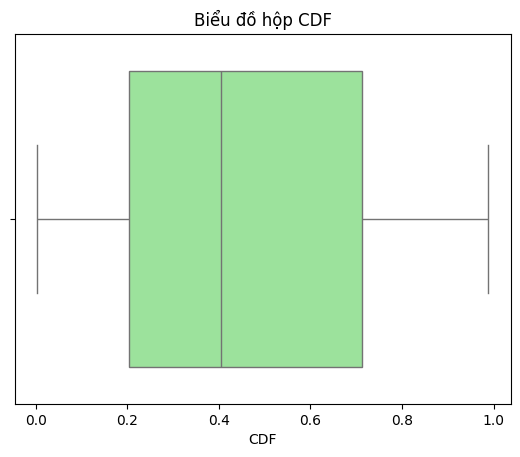

In [10]:
for col in lst_input:
    plt.Figure(figsize=(10, 6))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Biểu đồ hộp {col}')
    plt.xlabel(col)
    plt.show()

In [11]:
# def plot_vpin(buckets, col):
#     plt.figure(figsize=(12,6))
#     plt.plot(buckets["Time"].dt.floor('h'), buckets[col], label=f'{col}', linewidth=1.5)
#     plt.title(f"Xu hướng {col} the thời gian")
#     plt.xlabel("Thời gian")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=30)
#     plt.show()
# plot_vpin(df, "VPIN")


In [12]:
df[lst_input].corr()

VPIN      Roll  RollImpact  KyleLambda  AmihudLambda  \
VPIN          1.000000 -0.679649   -0.677290    0.237292      0.203499   
Roll         -0.679649  1.000000    0.999925   -0.232162     -0.375643   
RollImpact   -0.677290  0.999925    1.000000   -0.227261     -0.380139   
KyleLambda    0.237292 -0.232162   -0.227261    1.000000      0.085562   
AmihudLambda  0.203499 -0.375643   -0.380139    0.085562      1.000000   
CDF           0.995725 -0.670738   -0.668443    0.249144      0.217440   

                   CDF  
VPIN          0.995725  
Roll         -0.670738  
RollImpact   -0.668443  
KyleLambda    0.249144  
AmihudLambda  0.217440  
CDF           1.000000

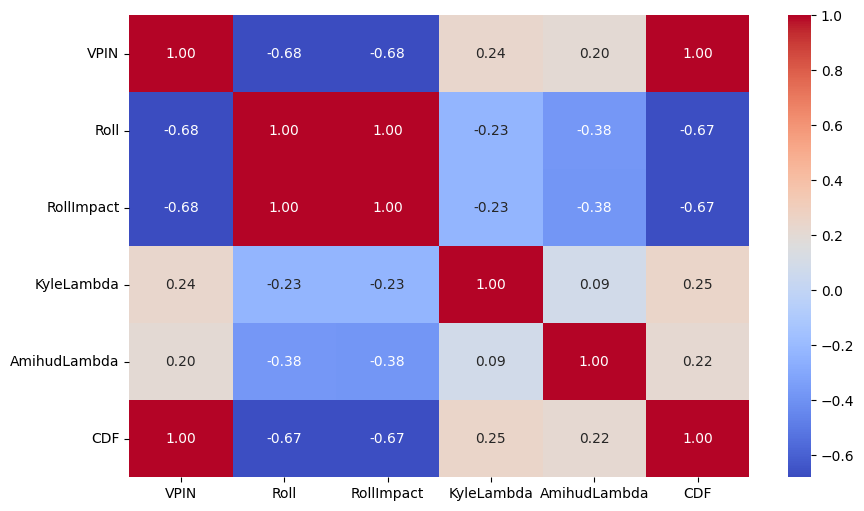

In [13]:
# heatmap:
plt.figure(figsize=(10, 6))
sns.heatmap(df[lst_input].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [14]:
# # Scatter plot
# plt.figure(figsize=(10, 6))
# sns.pairplot(df[['VPIN', 'Roll', 'RollImpact', 'AmihudLambda', "CDF"]])
# plt.show()

# Phân tích mối quan hệ giữa VPIN và các biến mục tiêu

In [15]:
# List các biến mục tiêu
target_cols = list_output

In [16]:
# Loại bỏ các dữ liệu Nan do việc tính toán các chỉ số thống kê cuộn
df = df.dropna(subset=target_cols + ['VPIN'])

<Figure size 1000x600 with 0 Axes>

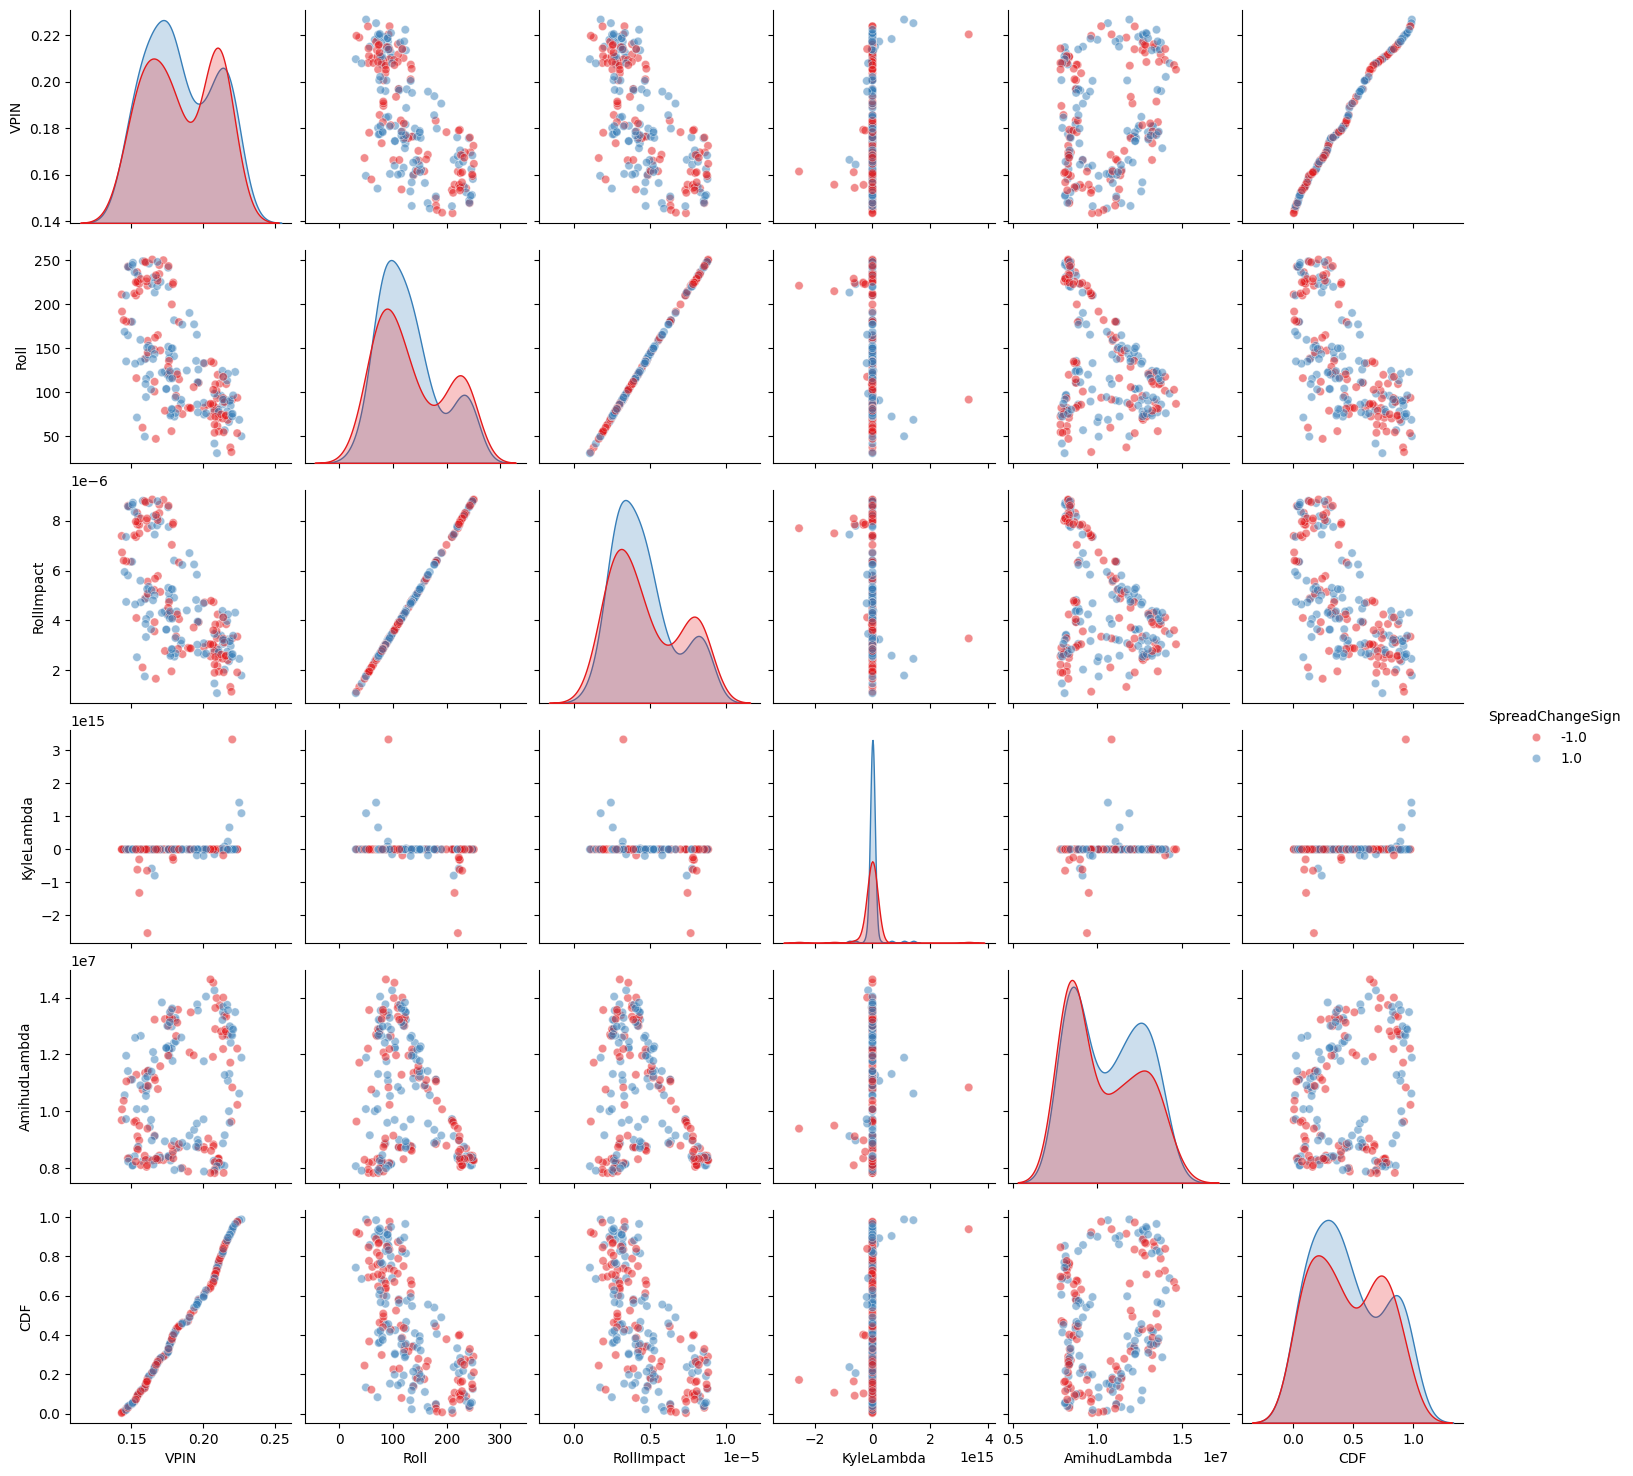

<Figure size 1000x600 with 0 Axes>

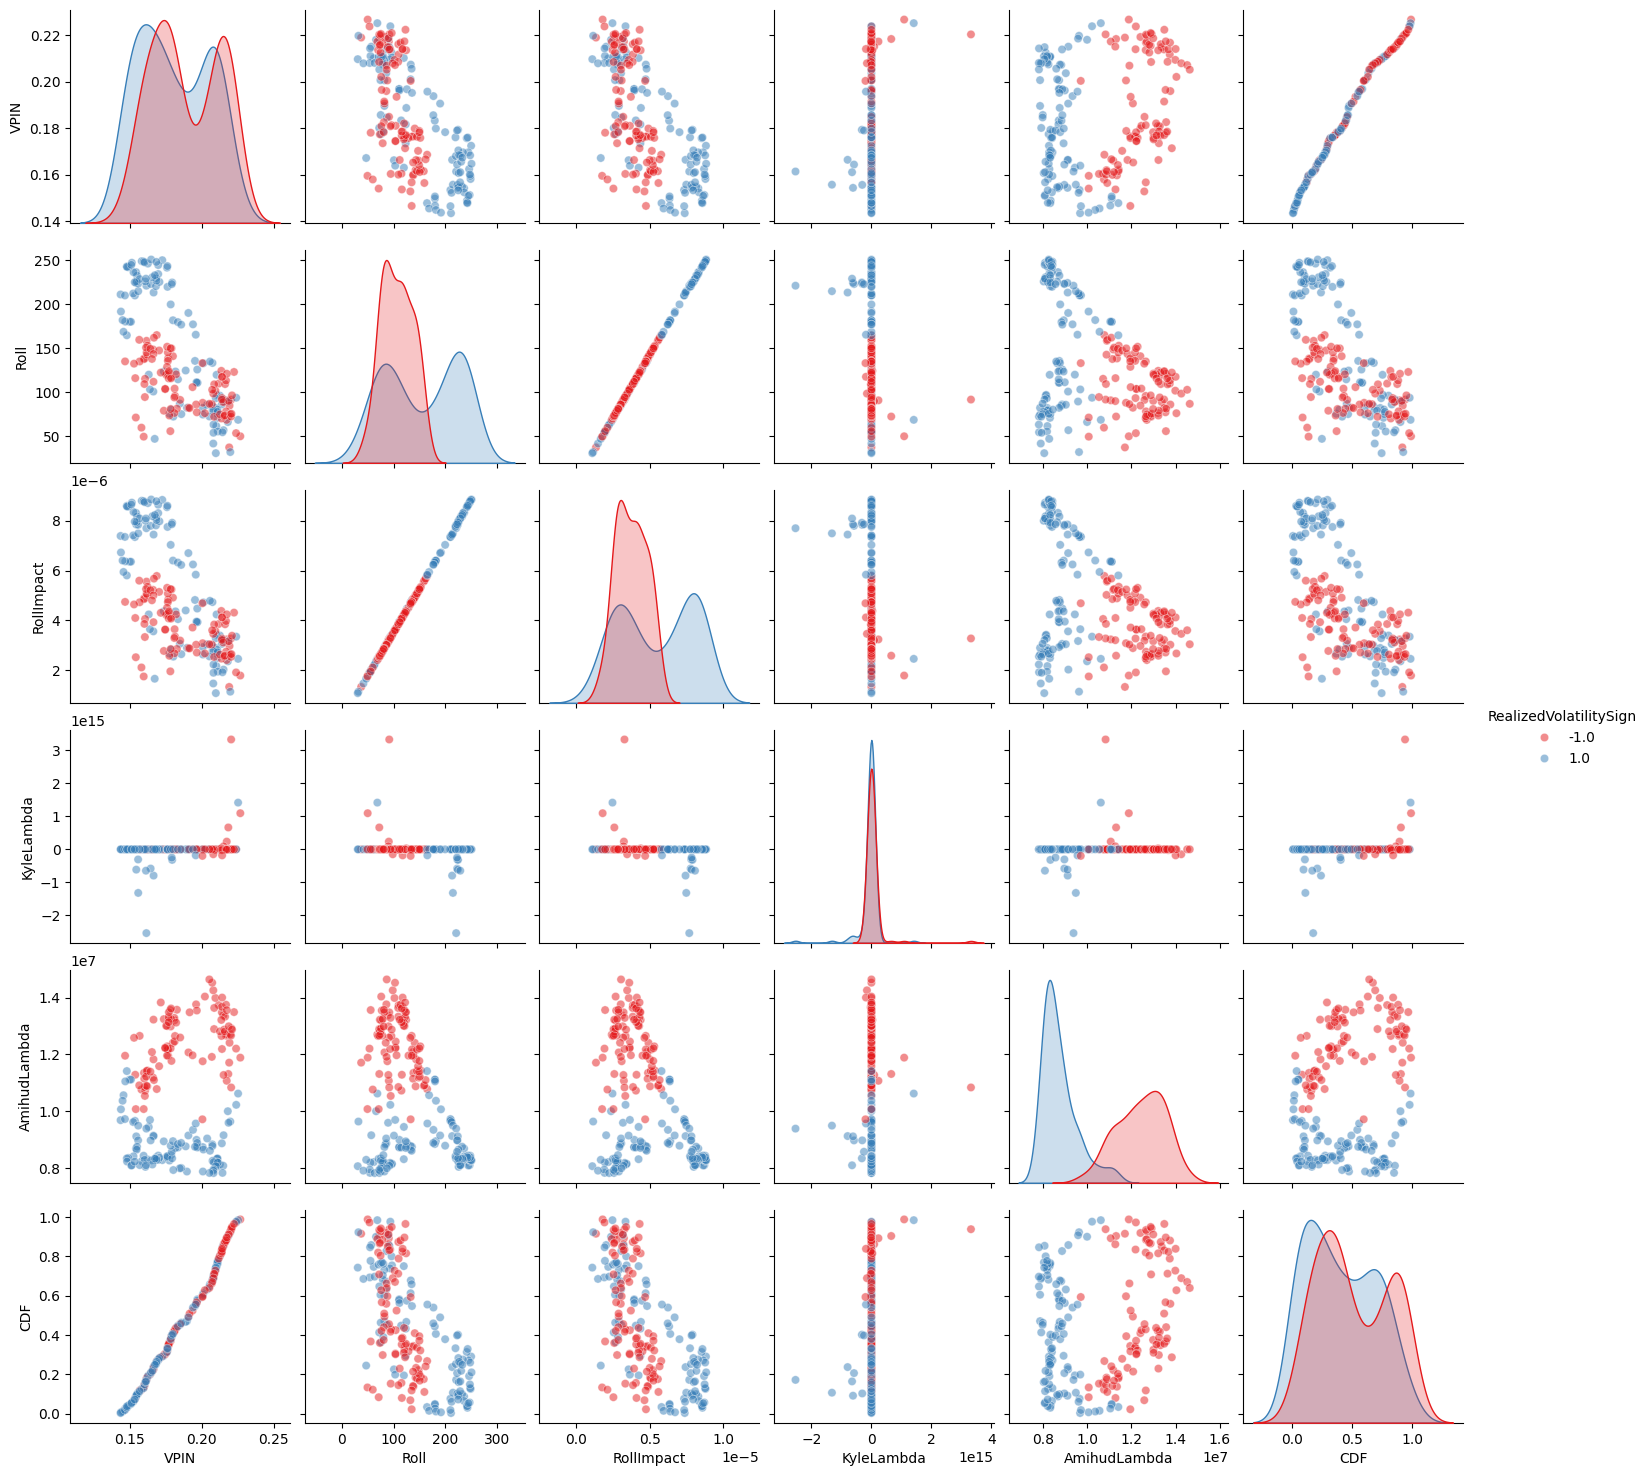

<Figure size 1000x600 with 0 Axes>

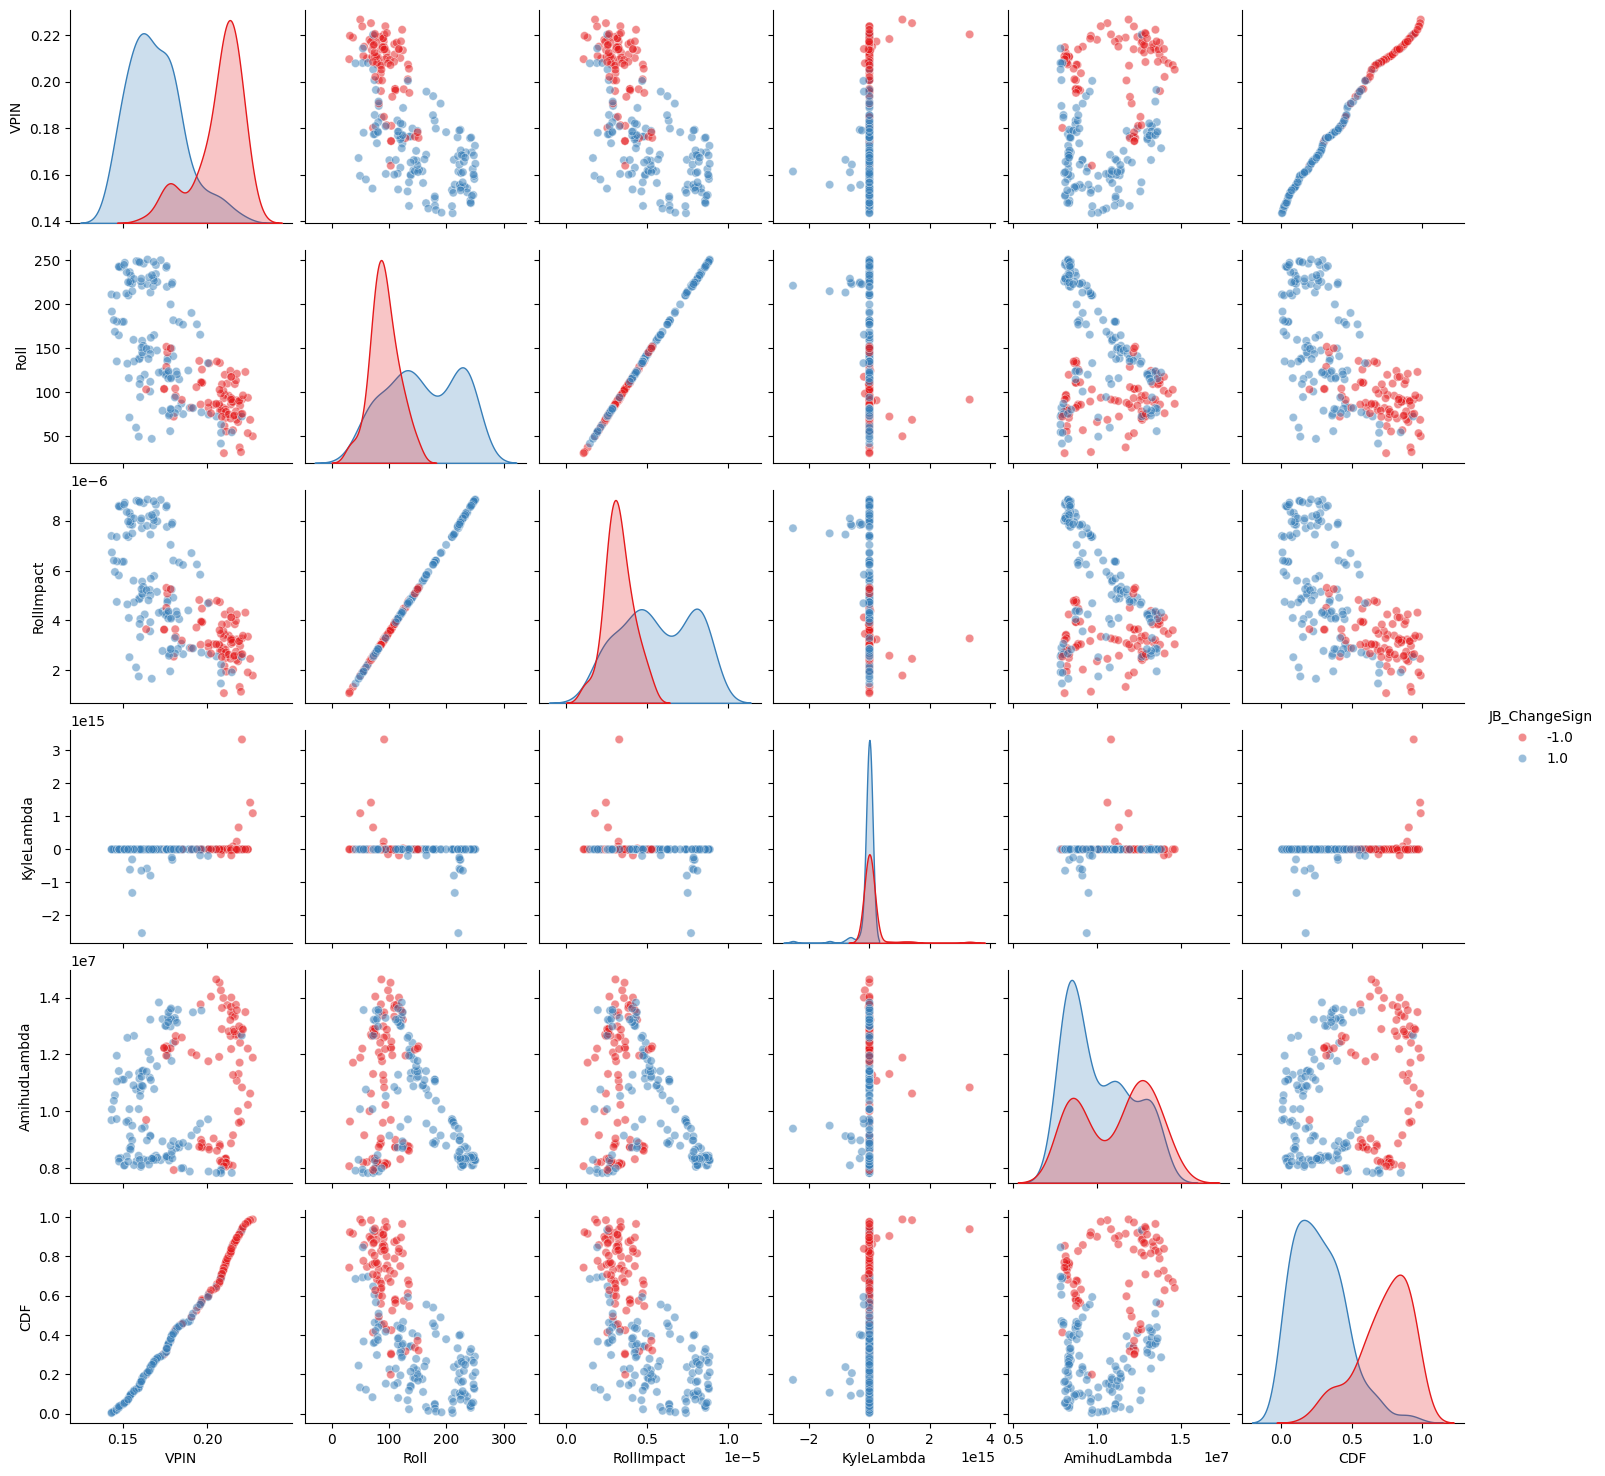

<Figure size 1000x600 with 0 Axes>

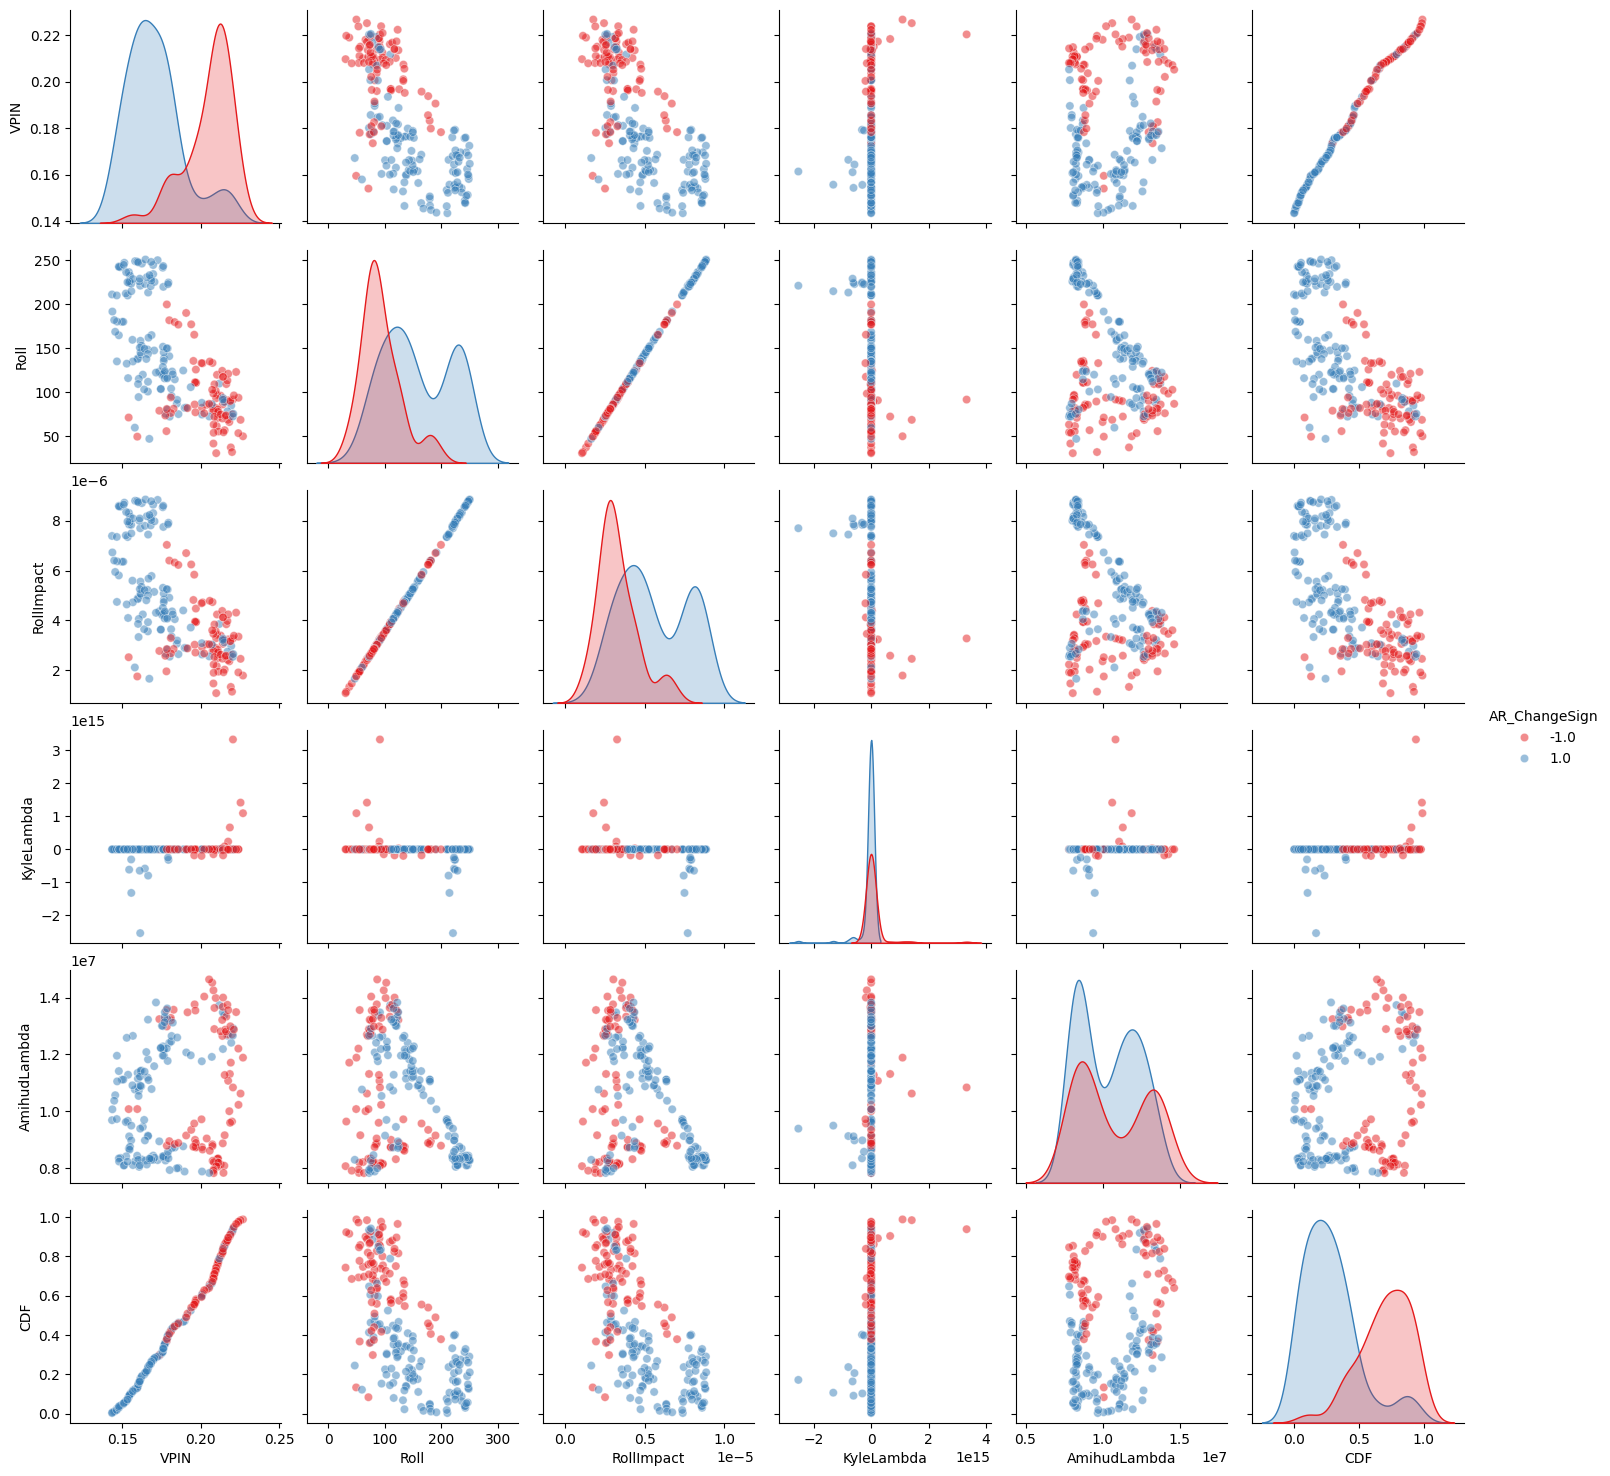

<Figure size 1000x600 with 0 Axes>

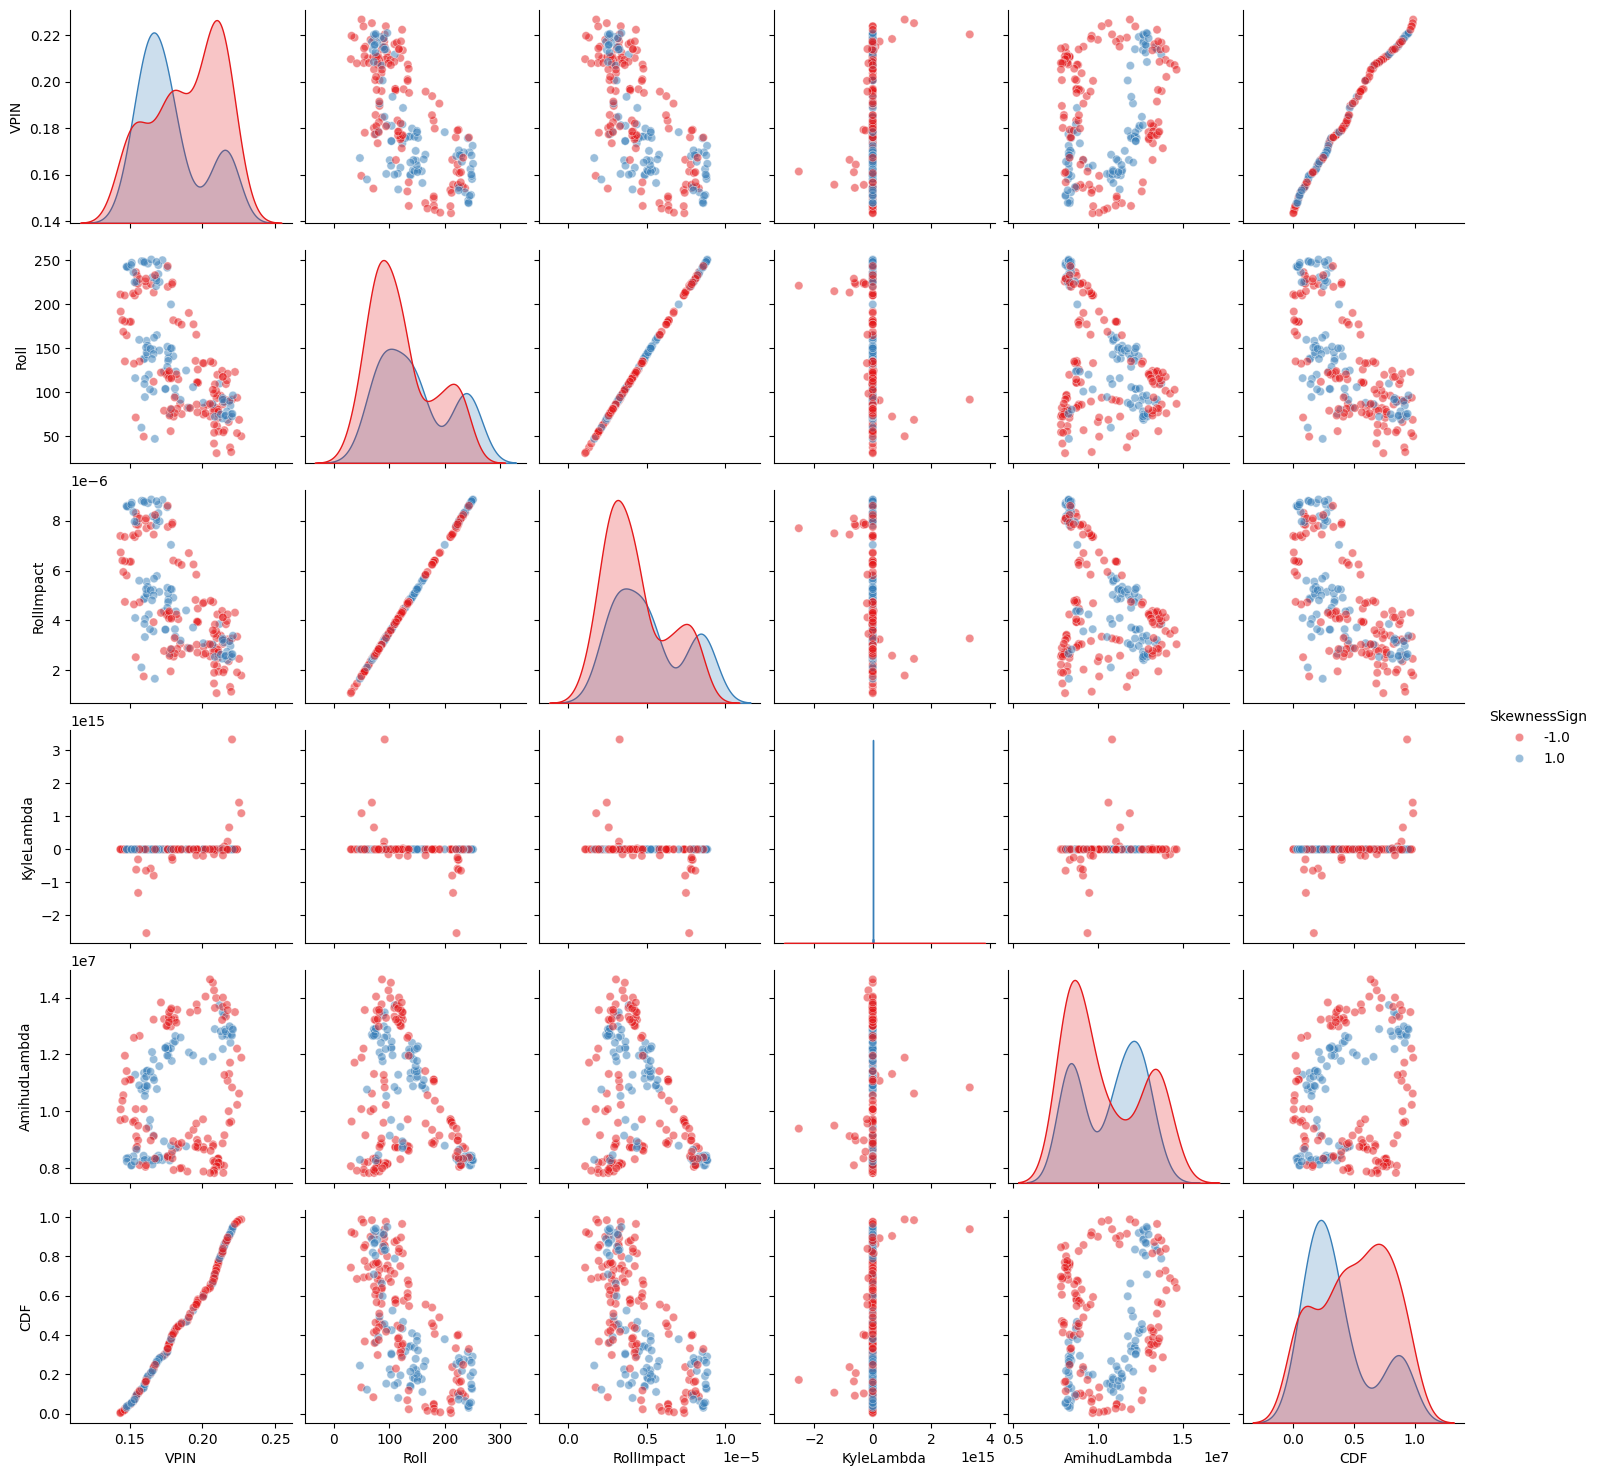

<Figure size 1000x600 with 0 Axes>

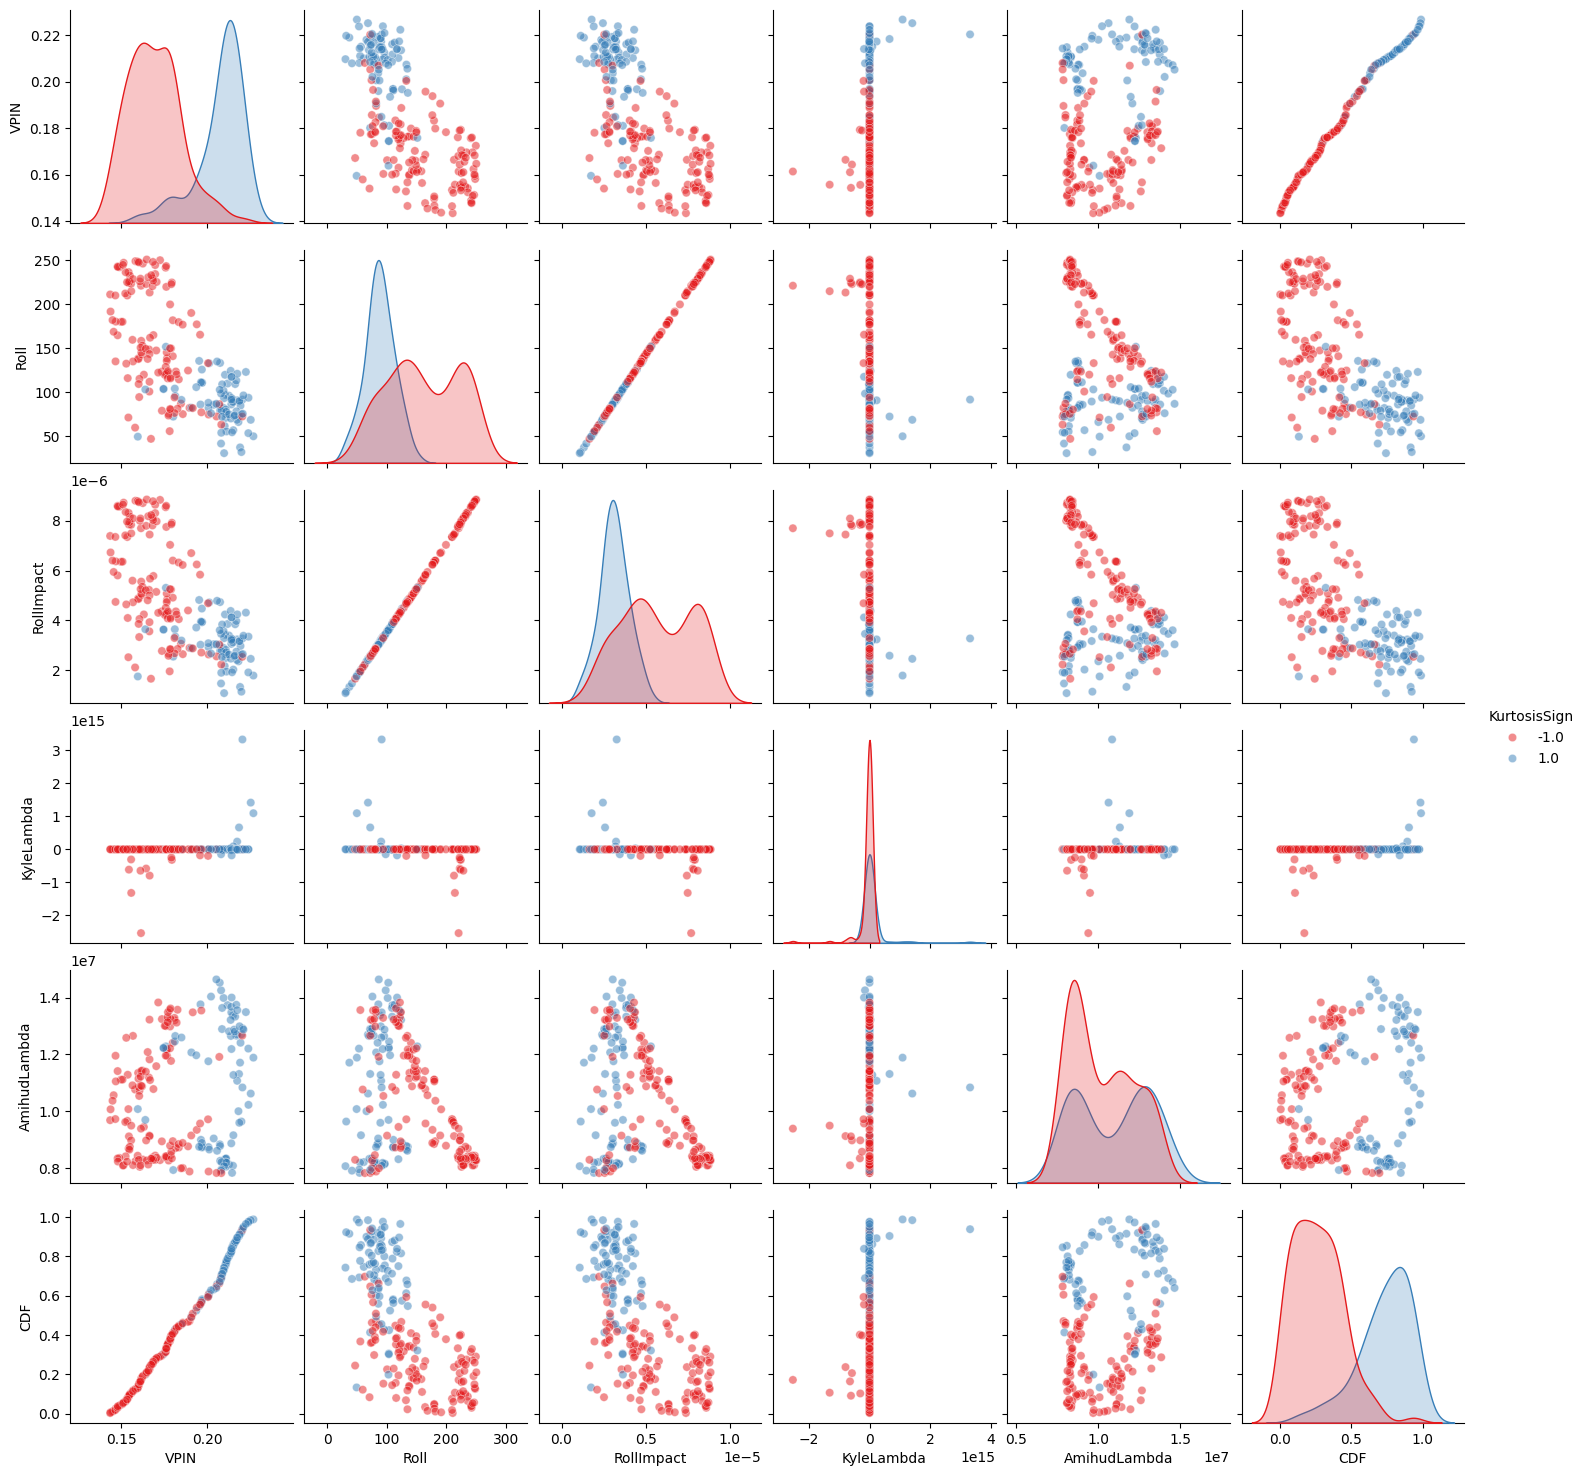

<Figure size 1000x600 with 0 Axes>

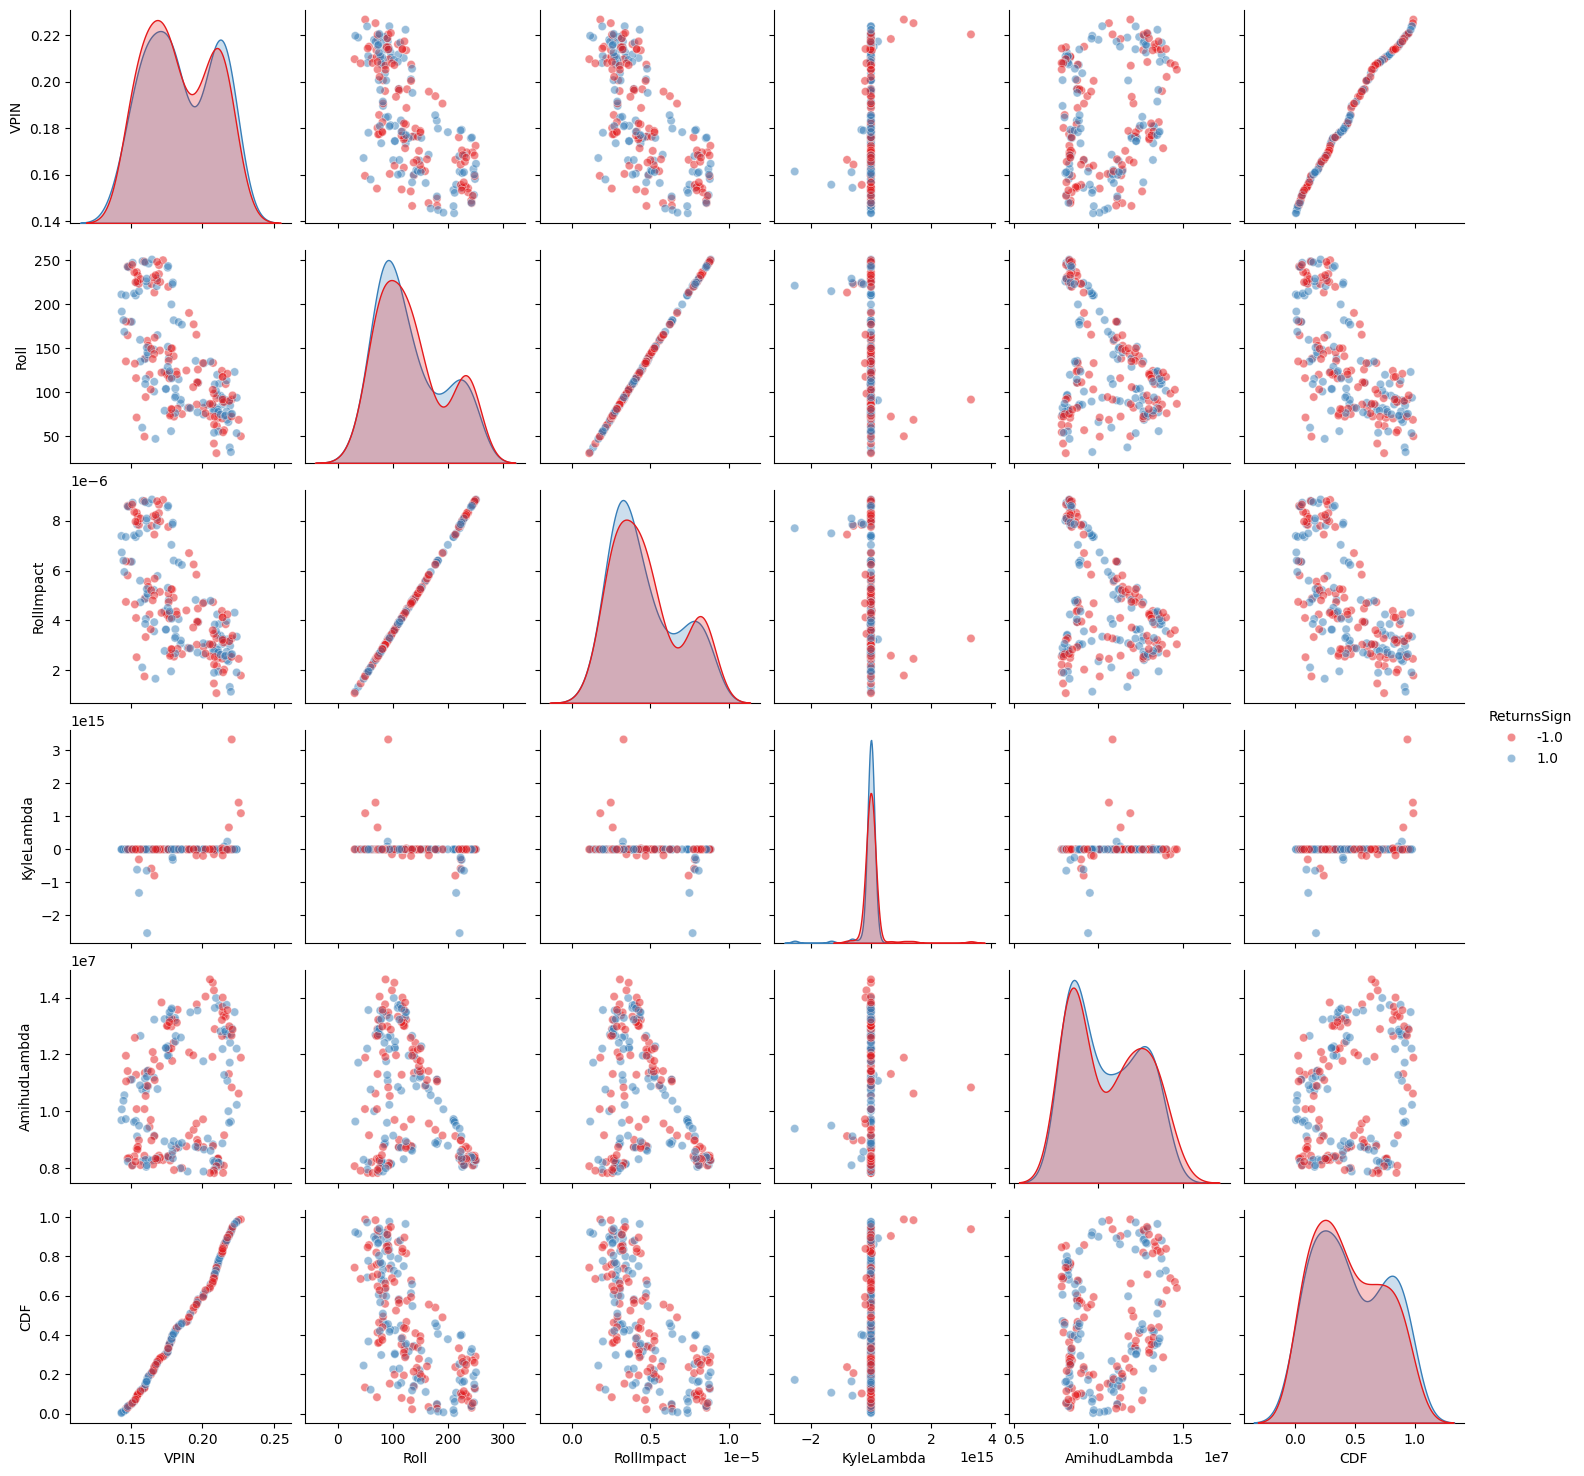

<Figure size 1000x600 with 0 Axes>

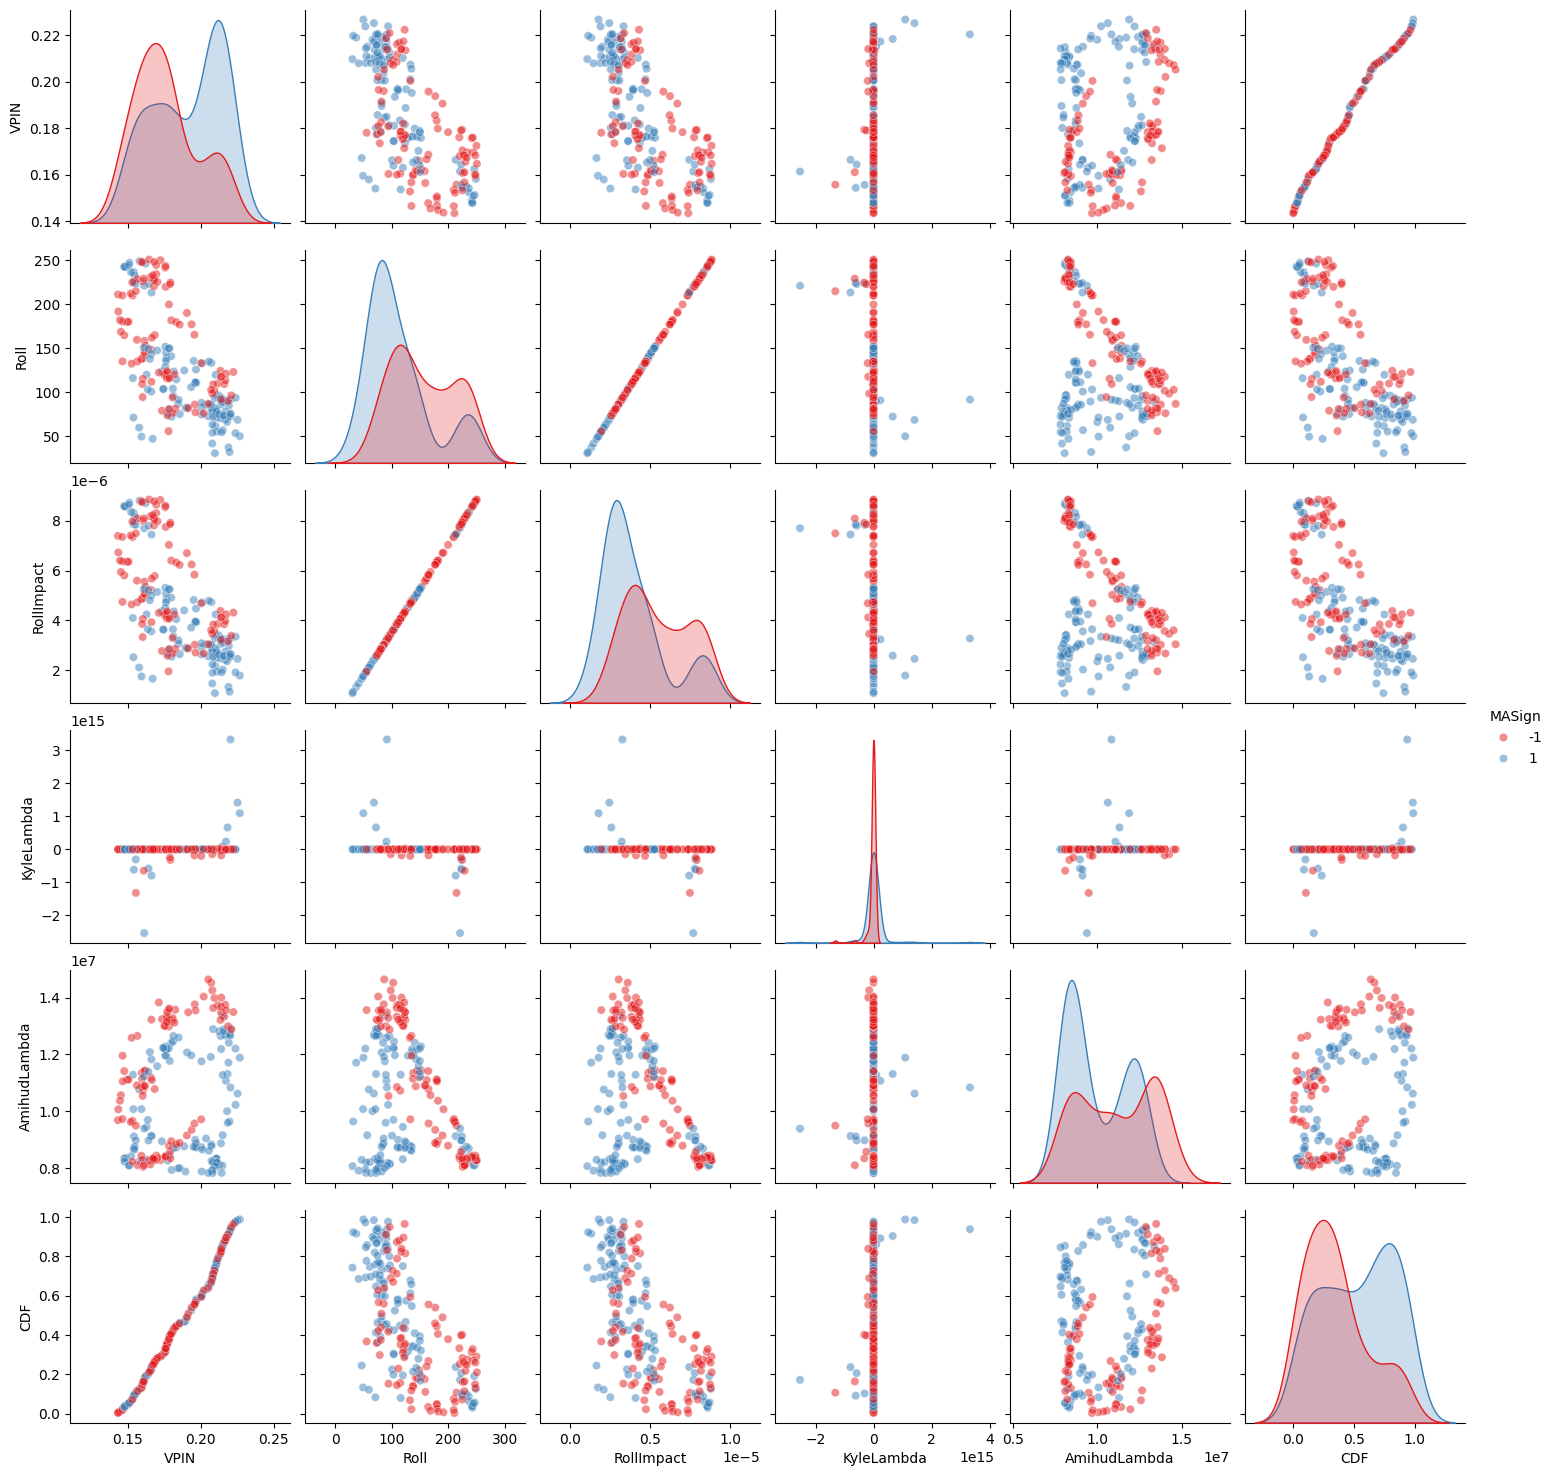

In [17]:
# Scatter plot
for col in target_cols:
    plt.figure(figsize=(10, 6))
    sns.pairplot(df, vars=lst_input,hue=col, palette='Set1', diag_kind='kde', markers='o', plot_kws={'alpha':0.5})
    plt.show()

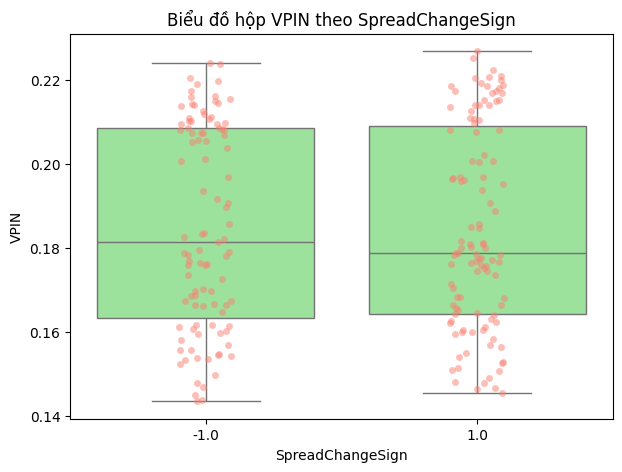

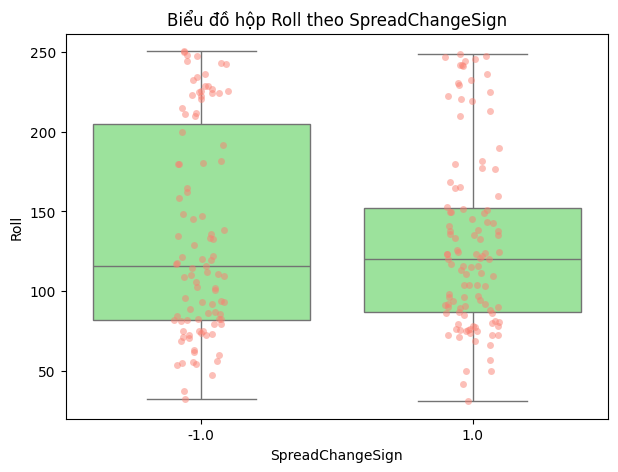

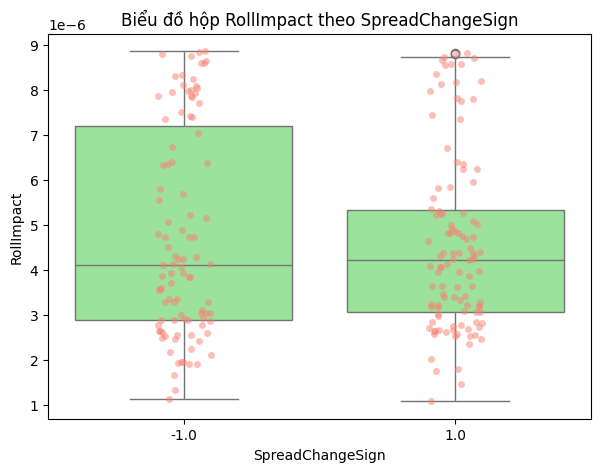

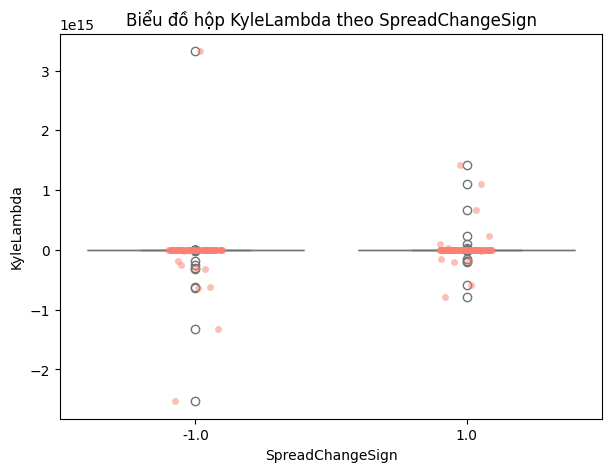

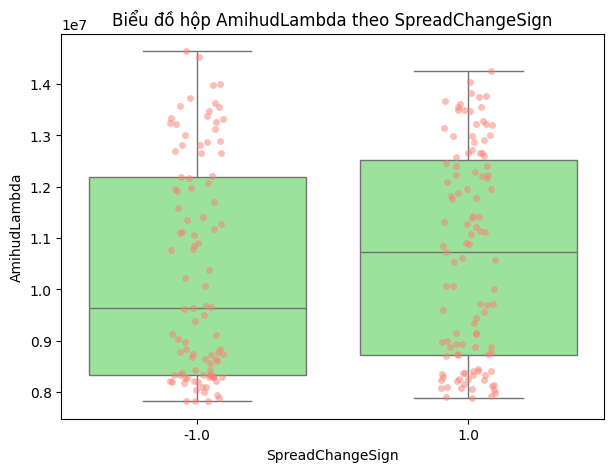

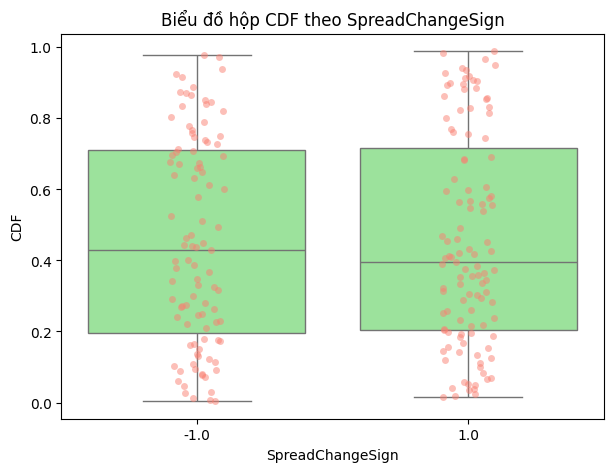

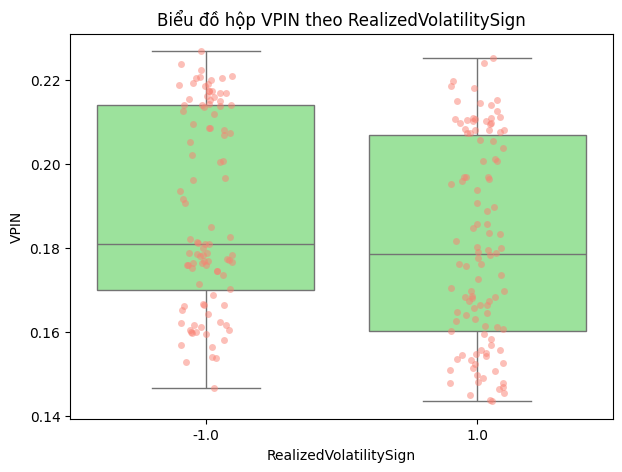

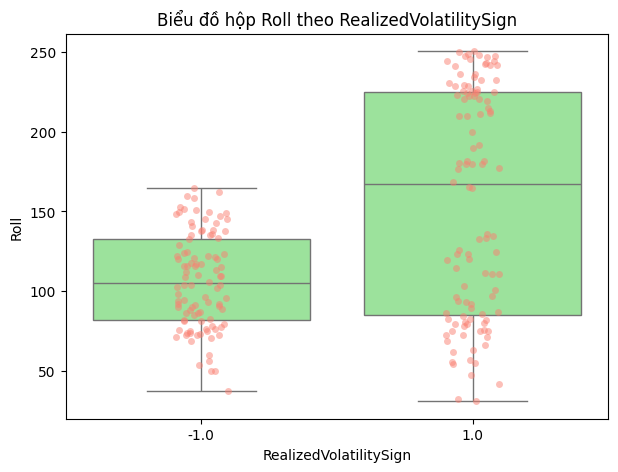

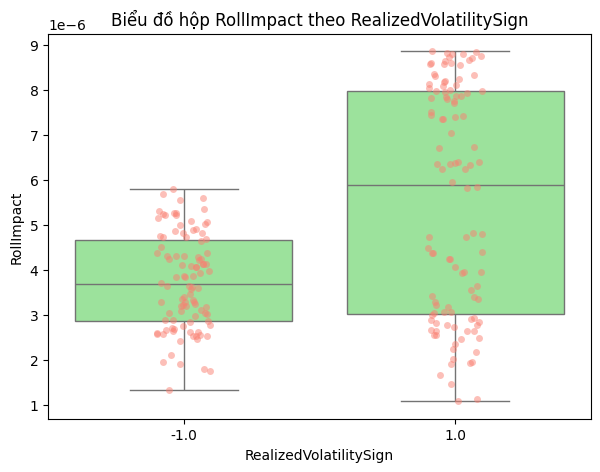

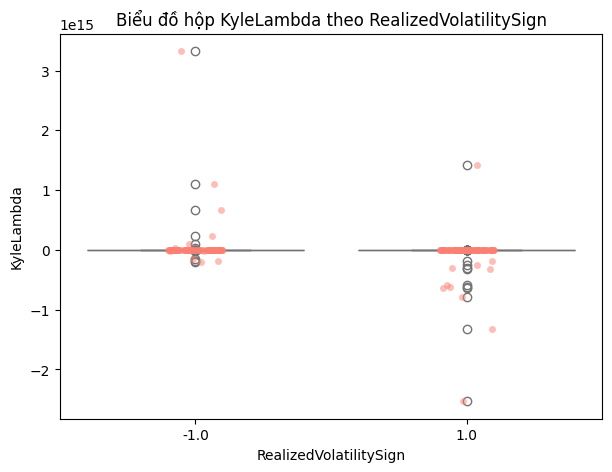

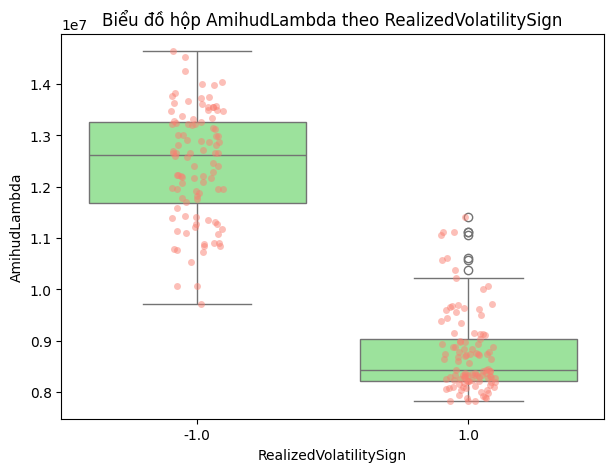

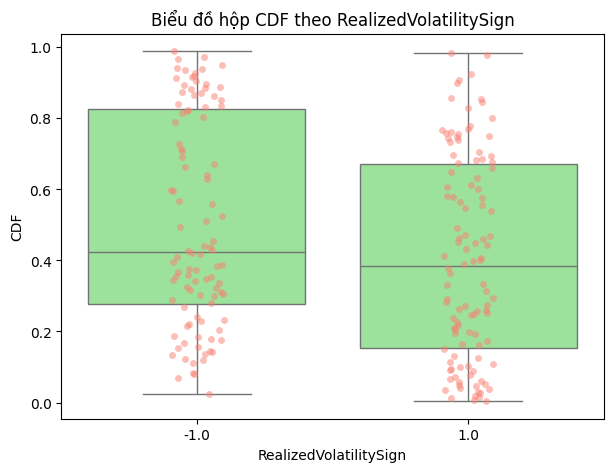

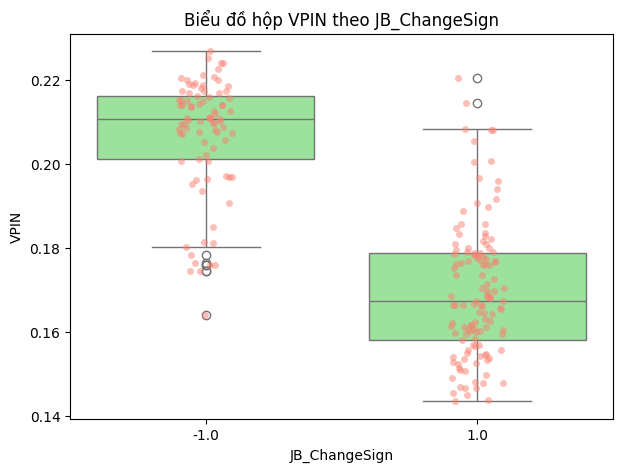

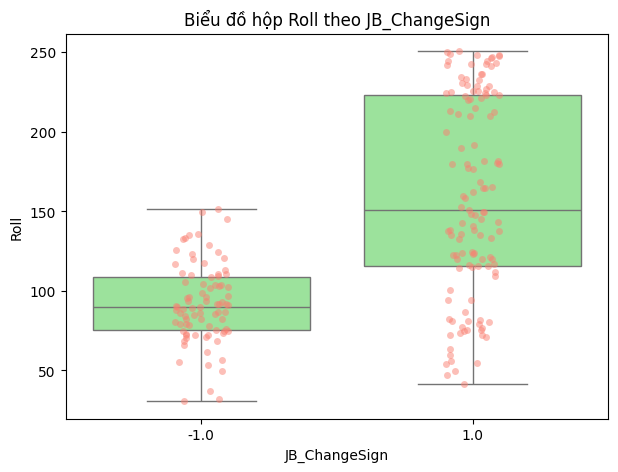

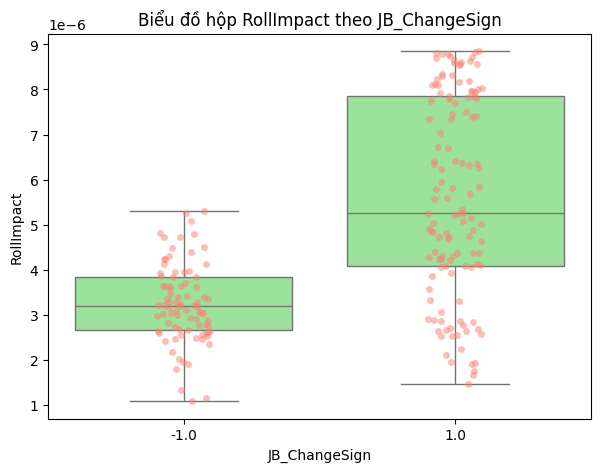

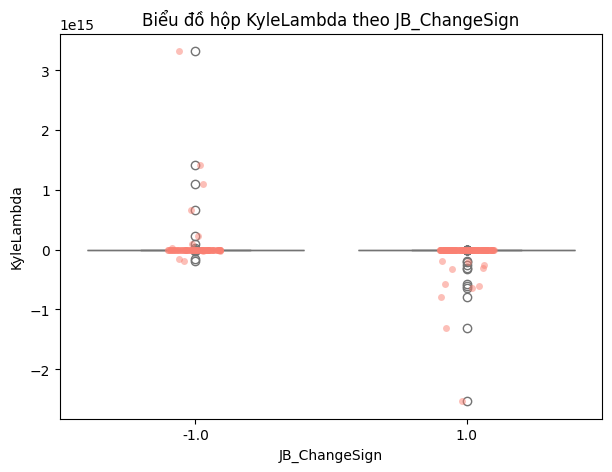

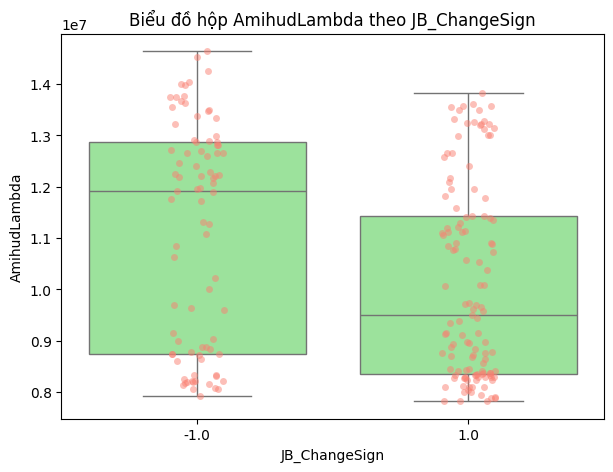

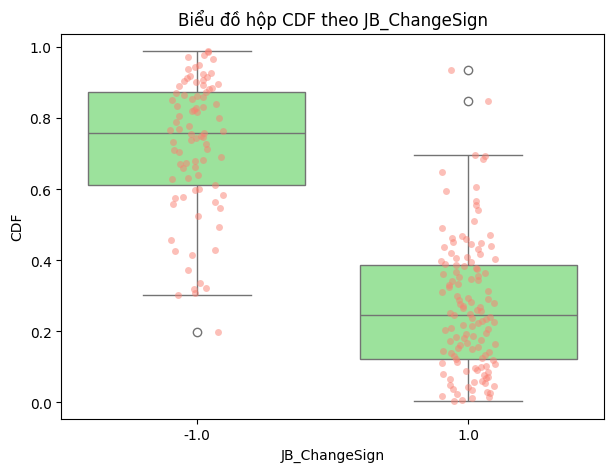

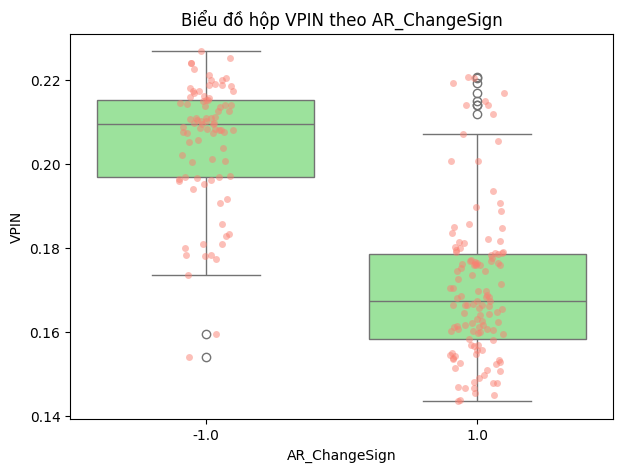

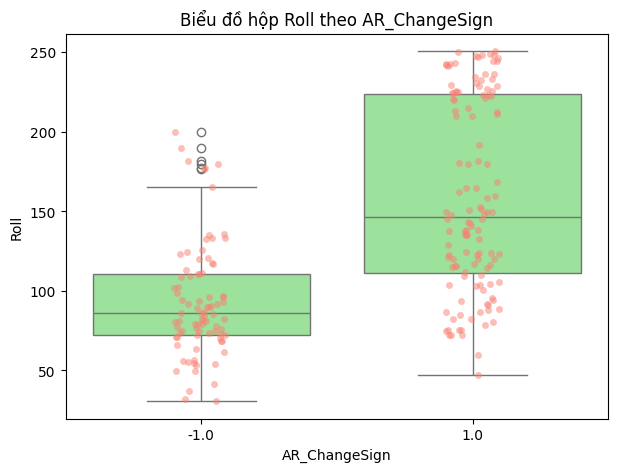

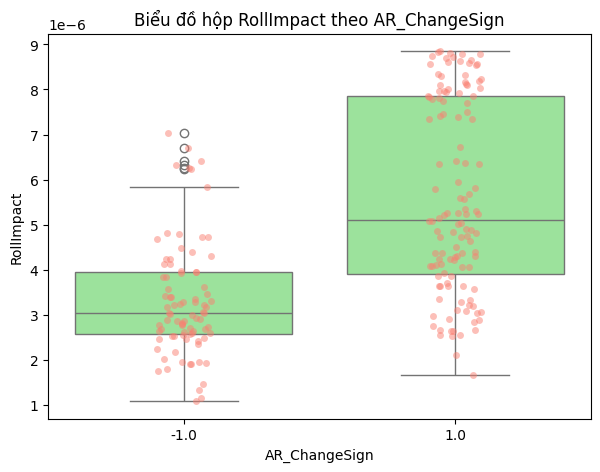

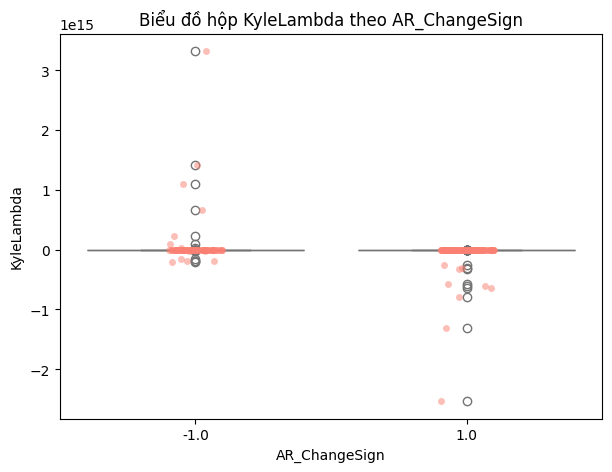

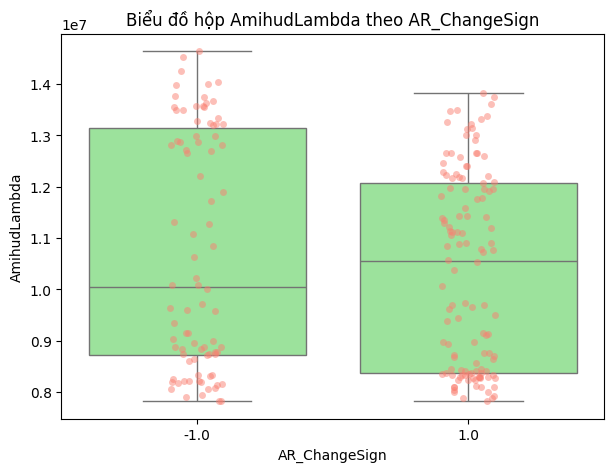

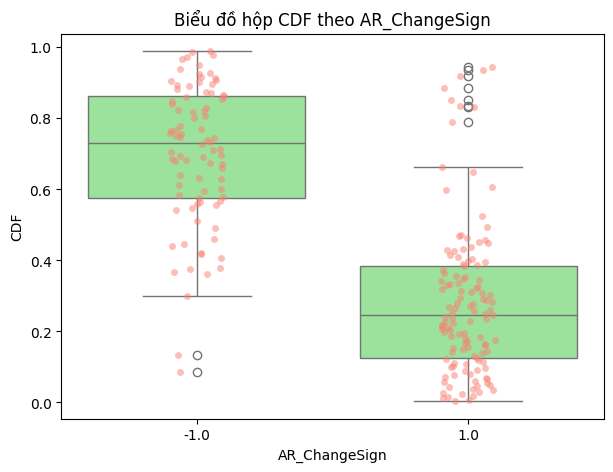

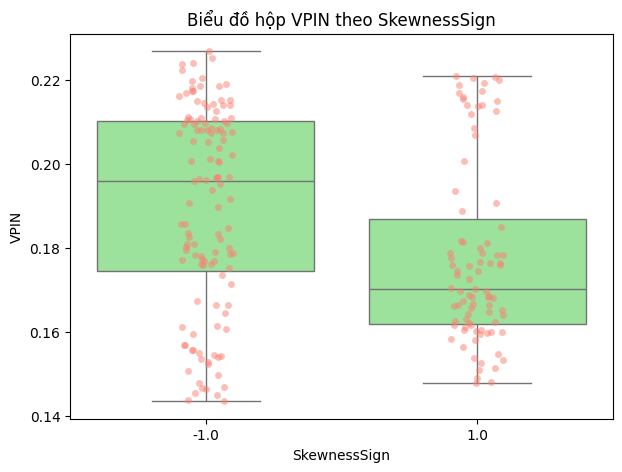

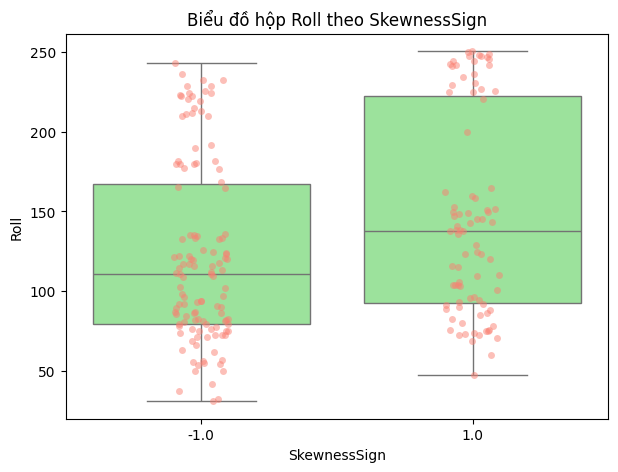

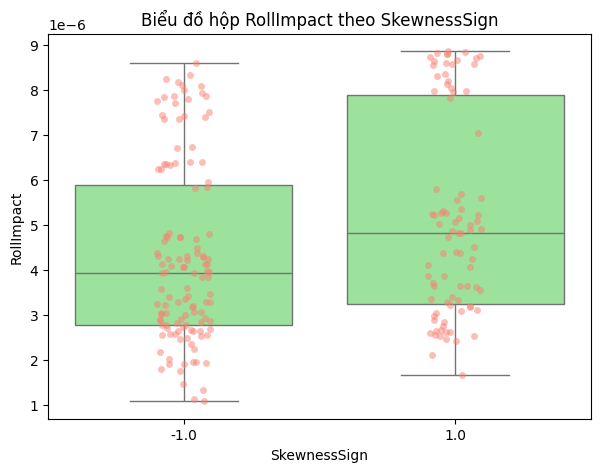

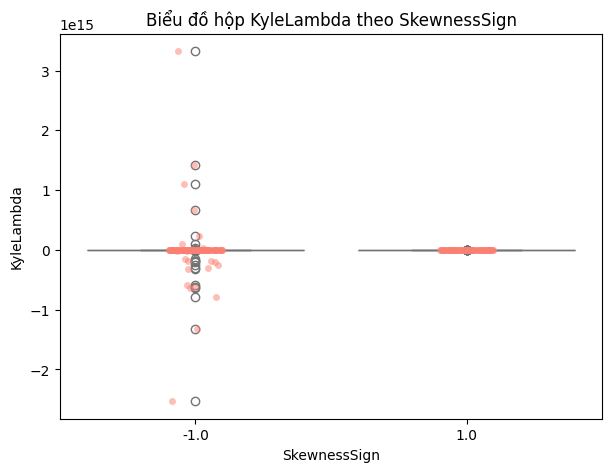

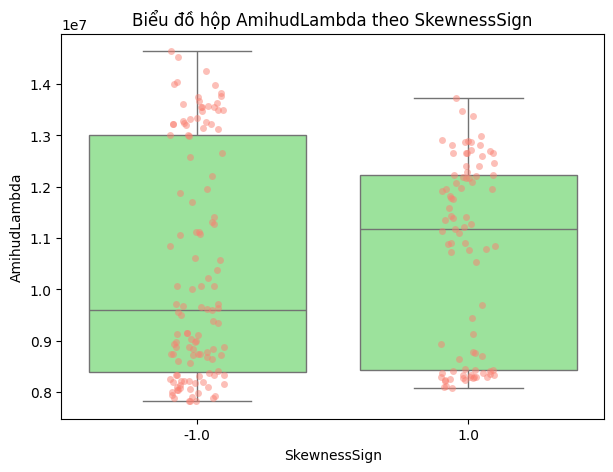

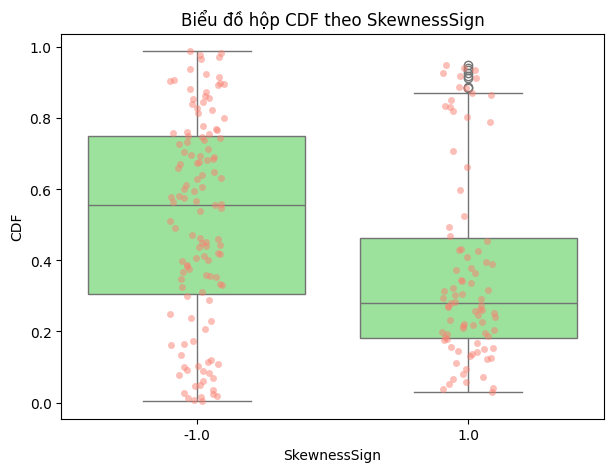

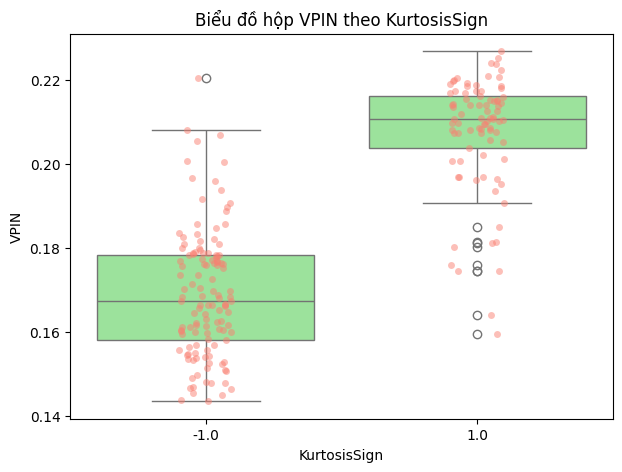

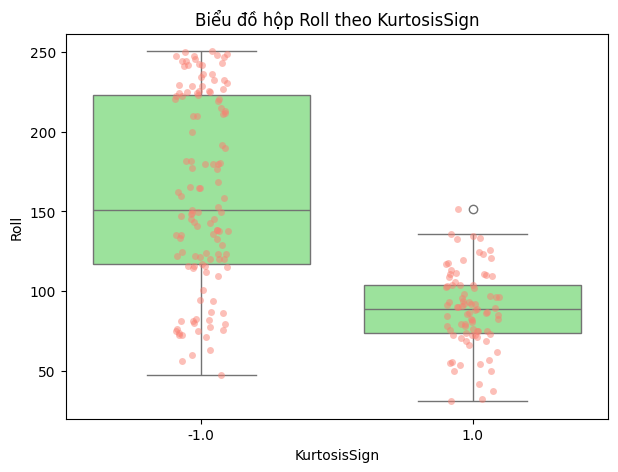

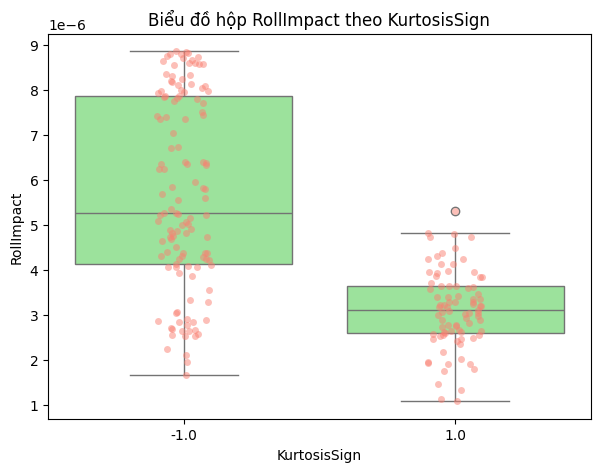

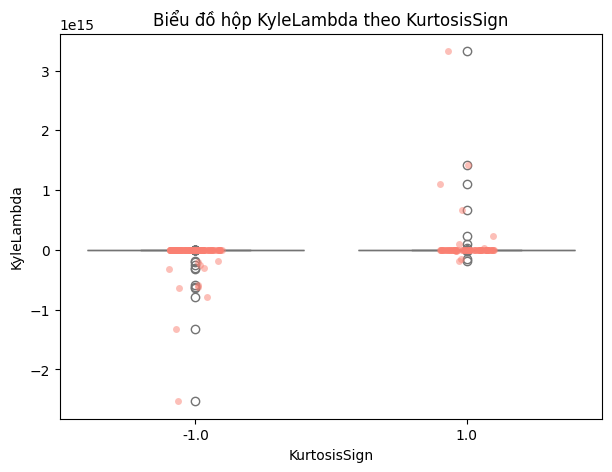

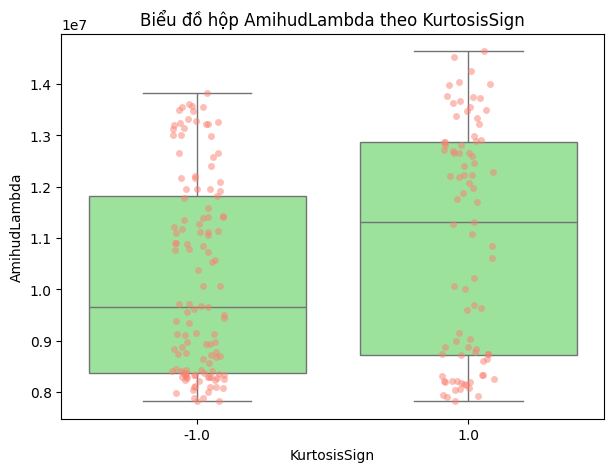

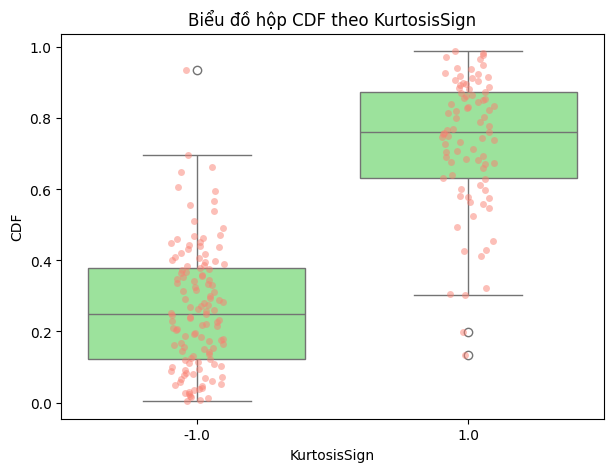

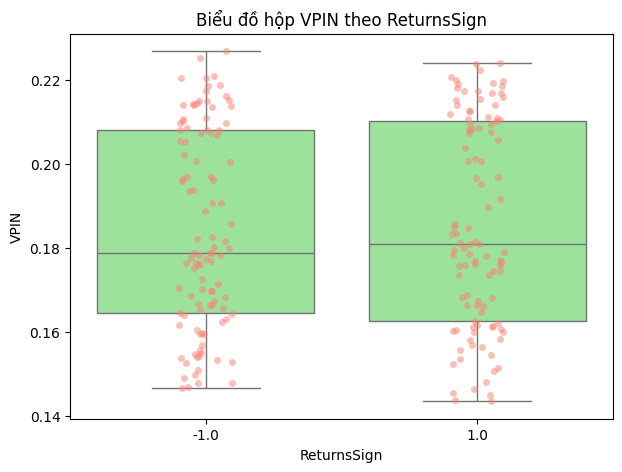

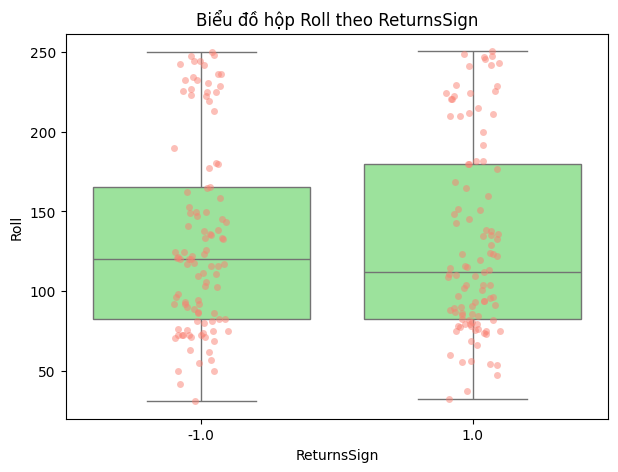

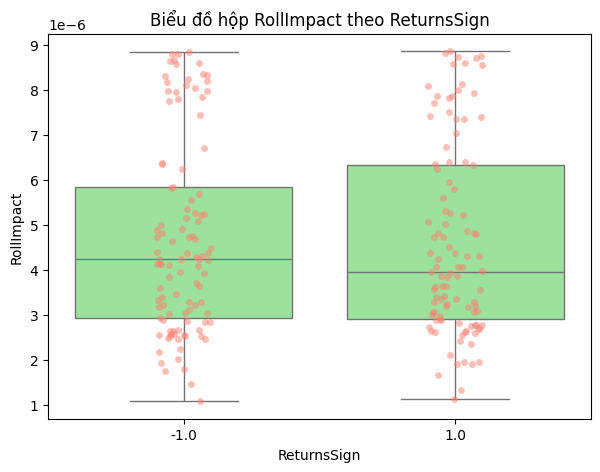

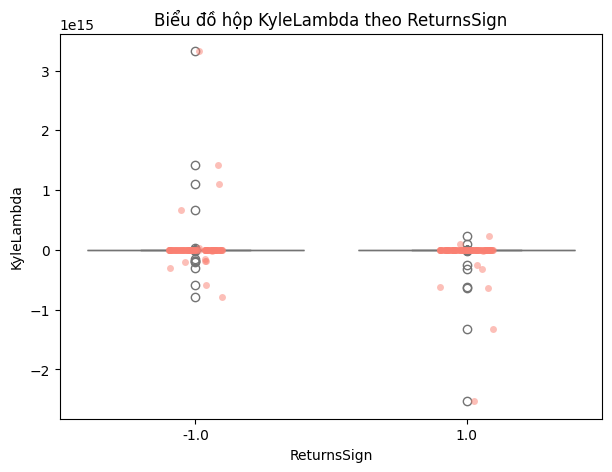

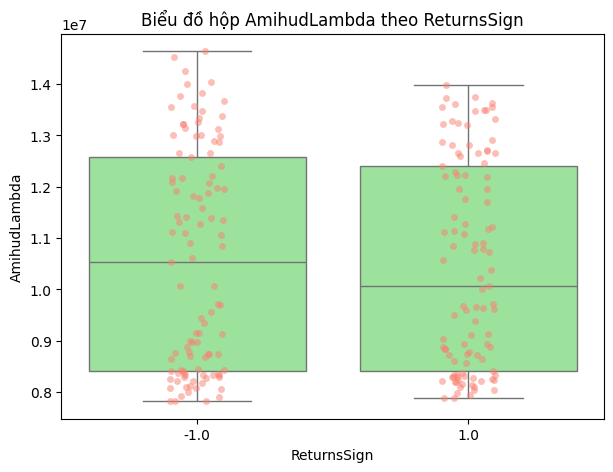

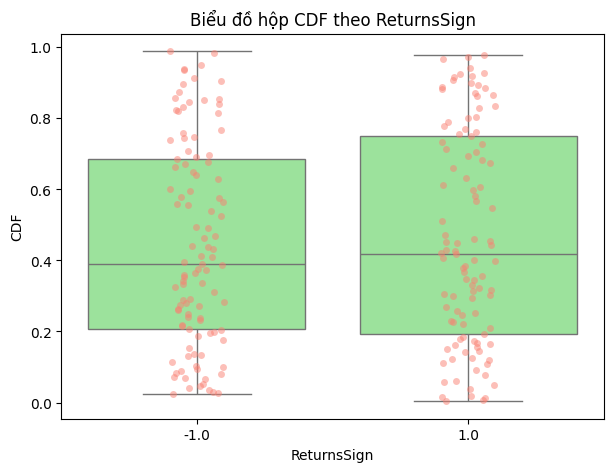

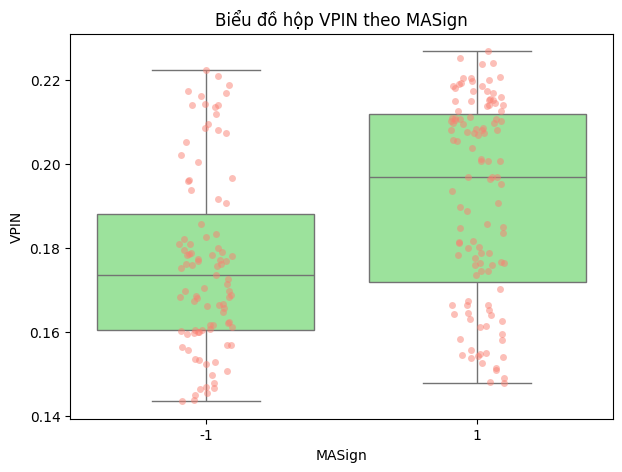

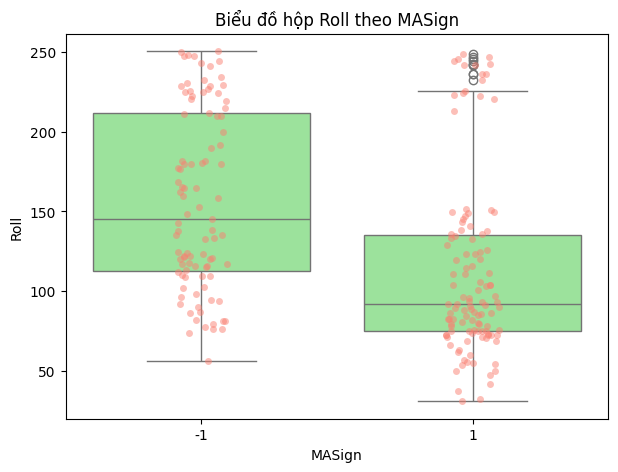

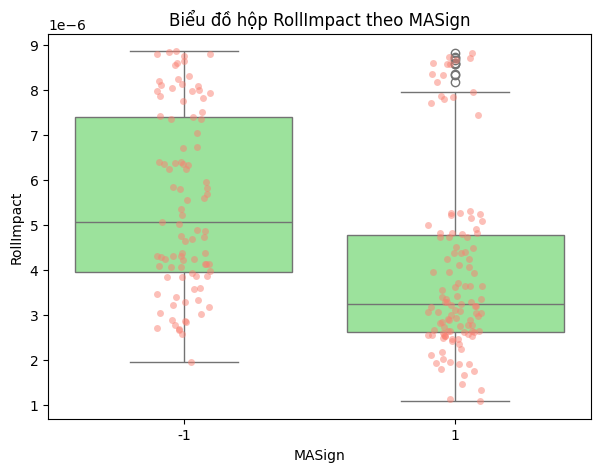

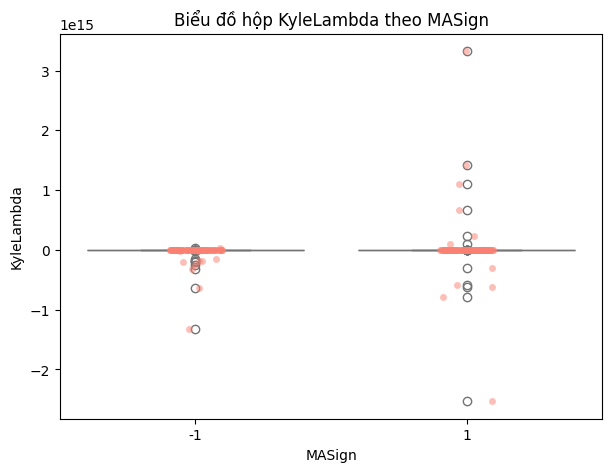

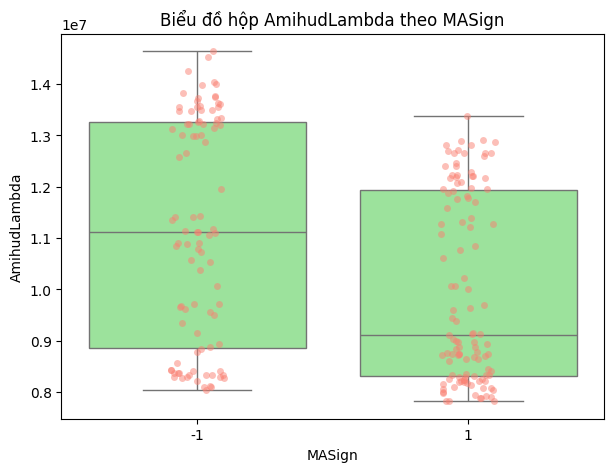

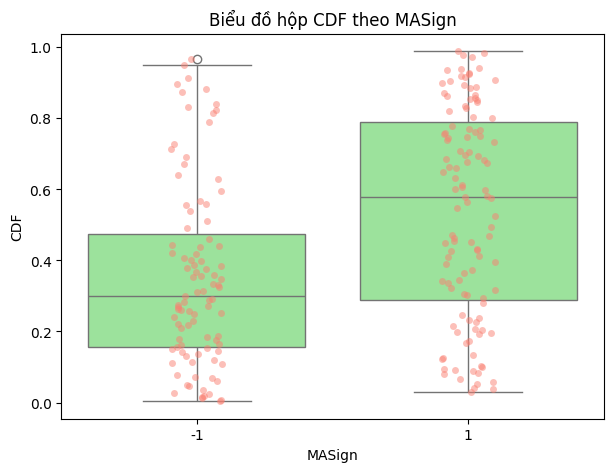

In [18]:
for col in target_cols:
    for col_in in lst_input:
        plt.figure(figsize=(7, 5))
        sns.boxplot(x=col, y=col_in, data=df, color='lightgreen')
        sns.stripplot(x=col, y=col_in, data=df, color='salmon', alpha=0.5, jitter=True)
        plt.title(f'Biểu đồ hộp {col_in} theo {col}')
        plt.show()

In [19]:
# for col in target_cols:
#     plt.figure(figsize=(6, 2))
#     sns.barplot(x=col, y='VPIN', data=df, color='lightgreen', errorbar=('ci', 95))
#     plt.title(f'Trung bình VPIN theo {col}')
#     plt.show()

# Kiểm định

### Kiểm tra phân phối của dữ liệu của các biến đầu vào

- Giả thuyết H0: Dữ liệu từng biến đầu vào tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu từng biến đầu không tuân theo phân phối chuẩn.

In [20]:
pvalue_normal_df = pd.DataFrame(index=lst_input, columns=["pvalue"])
for col in lst_input:
    stat, p = shapiro(df[col].dropna())
    # print(f'Shapiro-Wilk test: p-value = {p}')
    pvalue_normal_df.loc[col, "pvalue"] = p
pvalue_normal_df

pvalue
VPIN            0.0
Roll            0.0
RollImpact      0.0
KyleLambda      0.0
AmihudLambda    0.0
CDF             0.0

Với mức ý nghĩa 5%:
- p rất bé => Bác bỏ giả thuyết H0. Chưa đủ bằng chứng để kết luận rằng dữ liệu của từng biến đầu vào có phân phối chuẩn

### Kiểm tra phân phối của các cột đầu vào theo từng nhóm

- Giả thuyết H0: Dữ liệu từng biến đầu vào cho từng nhóm có phân phối chuẩn
- Giả thuyế H1: Dữ liệu từng biến đầu cho từng nhóm không có phân phối chuẩn

In [21]:

pvalue_normal_1 = pd.DataFrame(index=target_cols, columns=lst_input)
pvalue_normal_minus1 = pd.DataFrame(index=target_cols, columns=lst_input)

for col in target_cols:
    for col_in in lst_input:
        # print(f"Kiểm định cho giá trị {col} - {col_in}")
        gr1 = df.loc[df[col] == 1, col_in]
        p1 = shapiro(gr1)[1]
        gr2 = df.loc[df[col] == -1, col_in]
        p2 = shapiro(gr1)[1]
        # print(f"pvalue với {col} = 1 cho {col_in}: ", p1)
        # print(f"pvalue với {col} = -1 cho {col_in}: ", p2)
        
        pvalue_normal_1.loc[col, col_in] = p1
        pvalue_normal_minus1.loc[col, col_in] = p2
pvalue_normal_1, pvalue_normal_minus1



(                            VPIN      Roll RollImpact KyleLambda AmihudLambda  \
 SpreadChangeSign        0.000043  0.000003   0.000002        0.0     0.000001   
 RealizedVolatilitySign  0.000021       0.0        0.0        0.0          0.0   
 JB_ChangeSign           0.000477   0.00001   0.000012        0.0          0.0   
 AR_ChangeSign           0.000001  0.000001   0.000001        0.0          0.0   
 SkewnessSign                 0.0  0.000002   0.000001        0.0          0.0   
 KurtosisSign                 0.0  0.886281   0.876829        0.0     0.000001   
 ReturnsSign             0.000023  0.000002   0.000003        0.0          0.0   
 MASign                  0.000001       0.0        0.0        0.0          0.0   
 
                              CDF  
 SpreadChangeSign        0.000024  
 RealizedVolatilitySign  0.000057  
 JB_ChangeSign           0.000061  
 AR_ChangeSign                0.0  
 SkewnessSign                 0.0  
 KurtosisSign            0.000072  
 Returns

- Bác bỏ giả thuyết H0 rằng data cho từng nhóm có phân phối chuẩn

- Dữ liệu của các cột input và dữ liệu của chúng theo từng nhóm đều không có phân phối chuẩn, ta dùng kiểm định mannwhitneyu để kiểm định xem  giá trị input có khác biệt giữa các nhóm phân loại hay không

### Kiểm định Mannwhitney U
- Giả thuyết không (H₀): Phân phối của hai nhóm là giống nhau (không có sự khác biệt về vị trí trung tâm).

- Giả thuyết đối (H₁): Phân phối của hai nhóm là khác nhau (có sự khác biệt về vị trí trung tâm).

In [22]:
pvalue_df = pd.DataFrame(index=target_cols, columns=lst_input)
for col in target_cols:
    for col_in in lst_input:
        gr1 = df.loc[df[col] == 1, col_in]
        gr2 = df.loc[df[col] == -1, col_in]
        stat, p = mannwhitneyu(gr1, gr2)
        pvalue_df.loc[col, col_in] = p
pvalue_df

VPIN      Roll RollImpact KyleLambda AmihudLambda  \
SpreadChangeSign        0.893227  0.989109   0.989109   0.193167     0.255341   
RealizedVolatilitySign  0.007369  0.000013   0.000009   0.543027          0.0   
JB_ChangeSign                0.0       0.0        0.0   0.000201     0.001343   
AR_ChangeSign                0.0       0.0        0.0   0.033141     0.182319   
SkewnessSign            0.001115  0.001828   0.002152   0.111679     0.423736   
KurtosisSign                 0.0       0.0        0.0   0.001343     0.032725   
ReturnsSign             0.636631  0.672698     0.6927   0.170828     0.738478   
MASign                  0.000011       0.0        0.0   0.000006     0.000011   

                             CDF  
SpreadChangeSign        0.893227  
RealizedVolatilitySign  0.007369  
JB_ChangeSign                0.0  
AR_ChangeSign                0.0  
SkewnessSign            0.001115  
KurtosisSign                 0.0  
ReturnsSign             0.636631  
MASign                  0.000011

- VPIN: phân biệt rõ các biến liên quan JB_ChangeSign và KurtosisSign.
- Roll & RollImpact: dự đoán tốt RealizedVolatilitySign, AR_ChangeSign, SkewnessSign, MASign.
- KyleLambda & AmihudLambda: nhạy với RealizedVolatilitySign, AR_ChangeSign, SkewnessSign.
#### Kết luận:
- Roll, RollImpact, Kyle, Amihud là predictors mạnh cho nhiều biến Sign khác nhau.
- VPIN lại đặc biệt nhạy với các biến mô tả phân phối (JB, Kurtosis).
- ReturnsSign và SpreadChangeSign gần như không được phân biệt bởi các metric này.

## Áp dụng model: RandomForest

### Chuẩn bị bộ dữ liệu

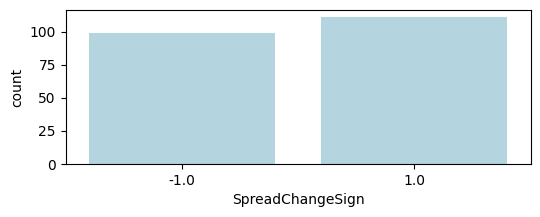

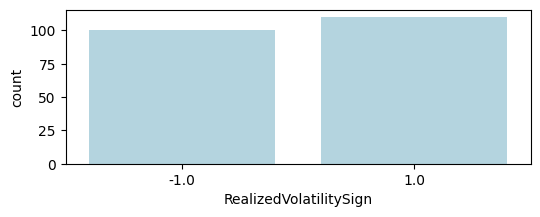

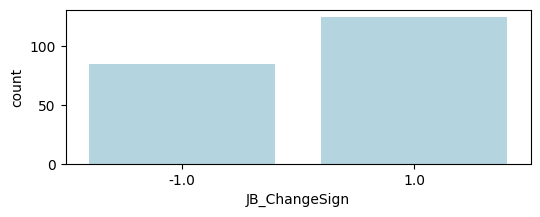

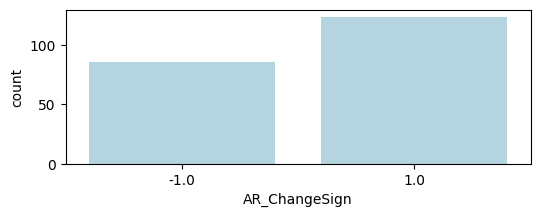

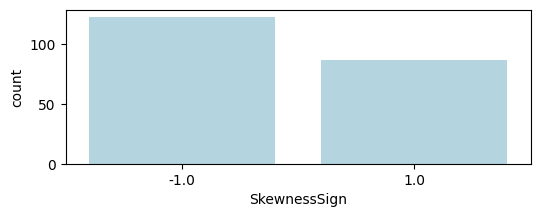

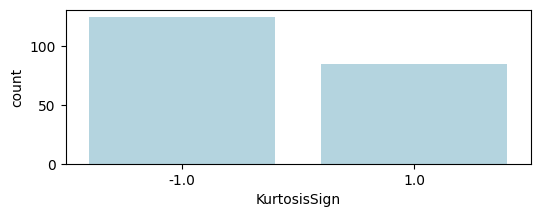

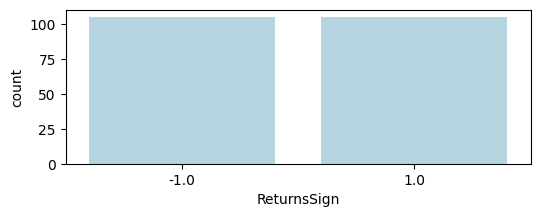

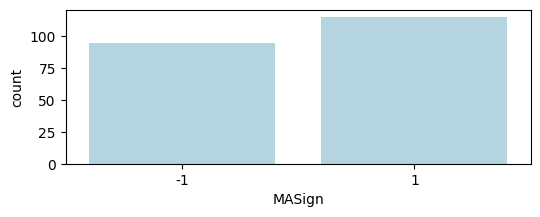

In [23]:
for col in target_cols:
    _ = pd.DataFrame(df[col].value_counts())
    plt.figure(figsize=(6, 2))
    sns.barplot(x=_.index, y=_["count"], color='lightblue', errorbar=('ci', 95))
    # plt.title(f'{col}')
    plt.show()

- Bộ dữ liệu có sự phân bố nhãn khá cân bằng giữa hai chiều giá trị (-1.0 và 1.0) ở các biến mục tiê. Mỗi biến đều có số lượng mẫu gần như tương đương giữa hai nhãn, với chênh lệch không đáng kể (dao động trong khoảng 2–14 mẫu). Điều này cho thấy bộ dữ liệu phù hợp để huấn luyện các mô hình học máy mà không cần xử lý mất cân bằng nhãn quá phức tạp.

In [24]:
train_data, test_data = {}, {}
for col in target_cols:
    data = df.copy()
    train_data[col], test_data[col] = train_test_split(data, test_size=0.3, random_state=42, stratify=data[col])
    

## Chỉ dùng VPIN làm biến đầu vào

In [25]:
train_cols = ["VPIN"]
acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.5873
              precision    recall  f1-score   support

        -1.0       0.57      0.57      0.57        30
         1.0       0.61      0.61      0.61        33

    accuracy                           0.59        63
   macro avg       0.59      0.59      0.59        63
weighted avg       0.59      0.59      0.59        63

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.6190
              precision    recall  f1-score   support

        -1.0       0.62      0.53      0.57        30
         1.0       0.62      0.70      0.66        33

    accuracy                           0.62        63
   macro avg       0.62      0.62      0.61        63
weighted avg       0.62      0.62      0.62        63

Độ chính xác của mô hình cho JB_ChangeSign: 0.8413
              precision    recall  f1-score   support

        -1.0       0.79      0.85      0.81        26
         1.0       0.89      0.84      0.86        37

    accuracy     

Accuracy
SpreadChangeSign         0.5873
RealizedVolatilitySign   0.6190
JB_ChangeSign            0.8413
AR_ChangeSign            0.8254
SkewnessSign             0.5238
KurtosisSign             0.8889
ReturnsSign              0.5079
MASign                   0.5873

## Dùng tất cả các biến input

In [26]:
train_cols = lst_input
acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
model_info = {}
for col in list_output:
    model_info[col] = {}
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    model_info[col]["y_test"] = test_data[col][col]

    model_info[col]["model"] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col]["model"].fit(X_train, y_train)

    model_info[col]["y_pred"] = model_info[col]["model"].predict(X_test)
    model_info[col]["y_prob"] = model_info[col]["model"].predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(model_info[col]["y_test"], model_info[col]["y_pred"])
    report = classification_report(model_info[col]["y_test"], model_info[col]["y_pred"], output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(model_info[col]["y_test"], model_info[col]["y_pred"]))
    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
print("Accuracy df:")
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.4603
              precision    recall  f1-score   support

        -1.0       0.44      0.53      0.48        30
         1.0       0.48      0.39      0.43        33

    accuracy                           0.46        63
   macro avg       0.46      0.46      0.46        63
weighted avg       0.46      0.46      0.46        63

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.9683
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97        30
         1.0       1.00      0.94      0.97        33

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

Độ chính xác của mô hình cho JB_ChangeSign: 0.9048
              precision    recall  f1-score   support

        -1.0       0.83      0.96      0.89        26
         1.0       0.97      0.86      0.91        37

    accuracy     

Accuracy
SpreadChangeSign         0.4603
RealizedVolatilitySign   0.9683
JB_ChangeSign            0.9048
AR_ChangeSign            0.9048
SkewnessSign             0.8889
KurtosisSign             0.8889
ReturnsSign              0.3968
MASign                   0.8889

SpreadChangeSign


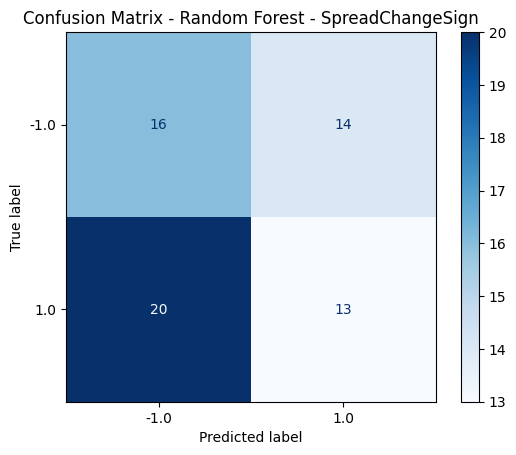

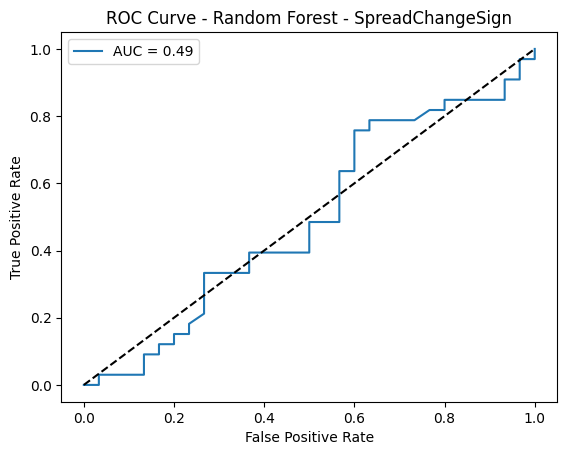

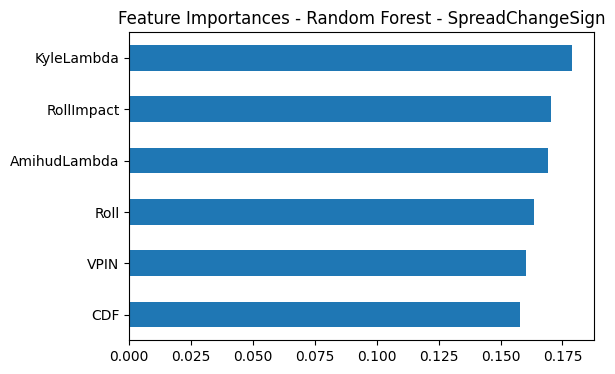

RealizedVolatilitySign


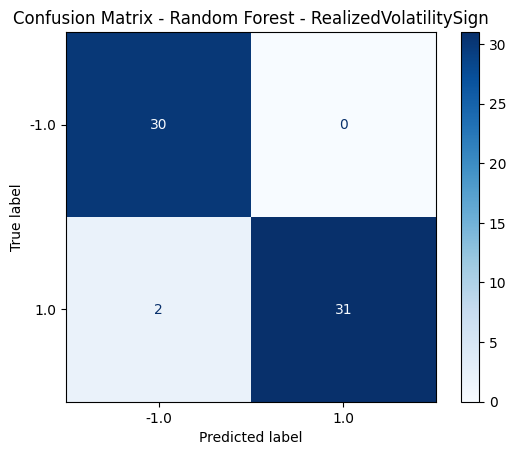

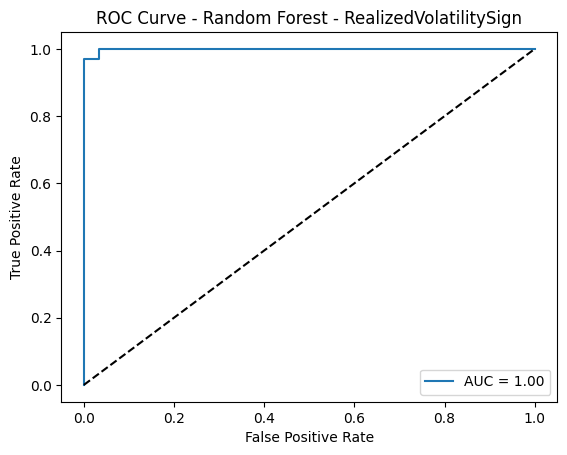

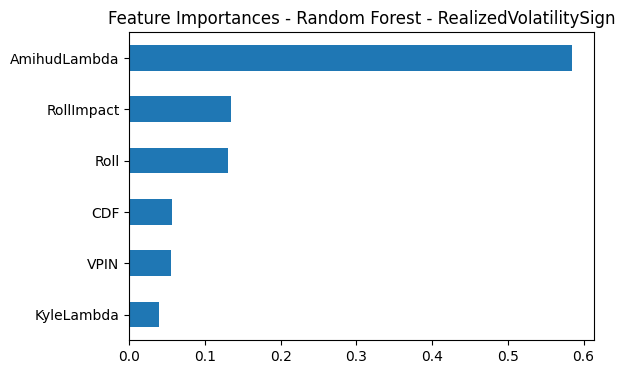

JB_ChangeSign


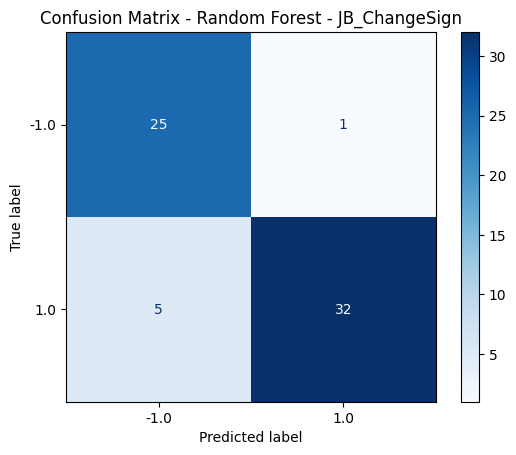

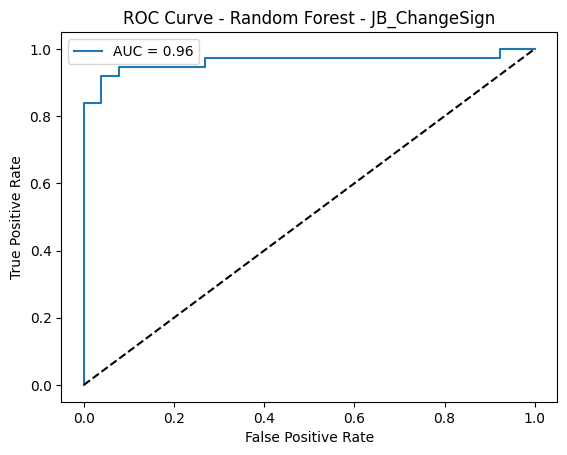

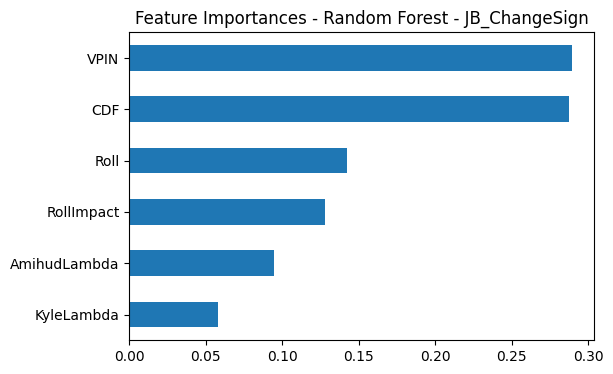

AR_ChangeSign


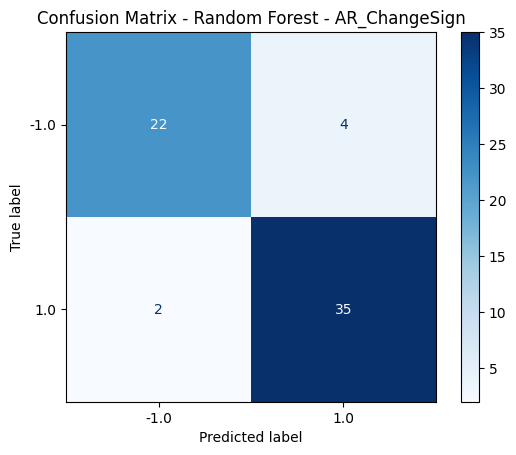

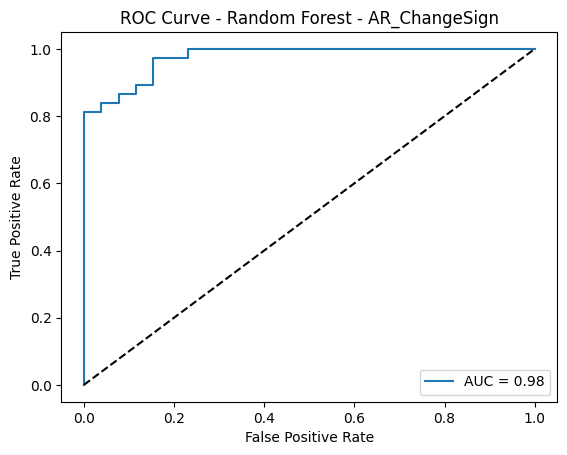

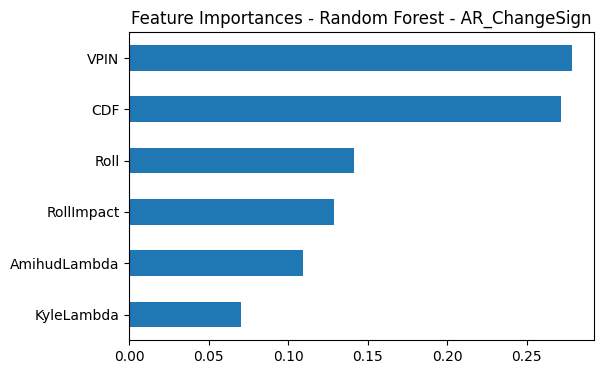

SkewnessSign


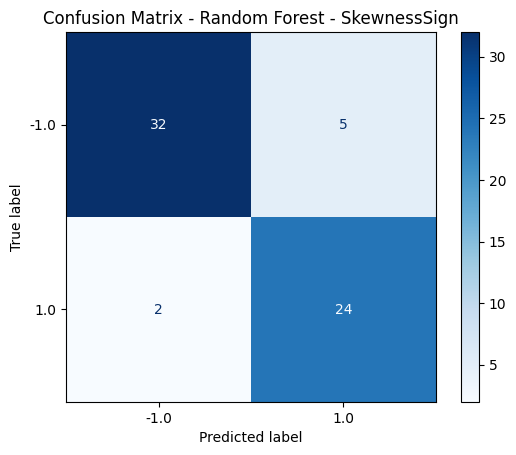

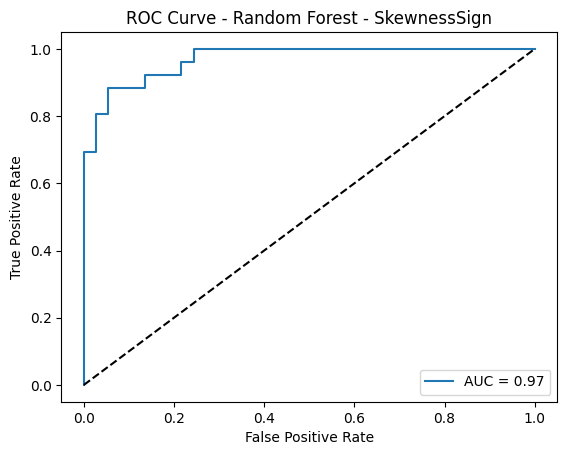

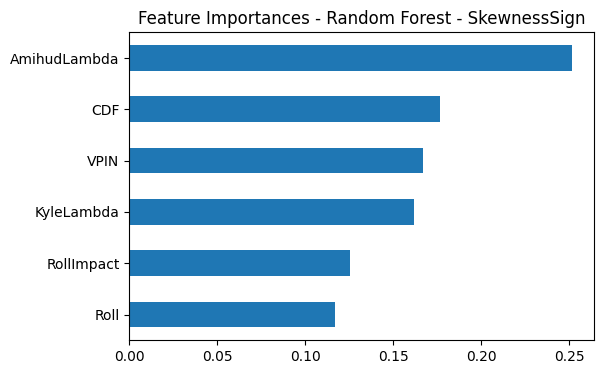

KurtosisSign


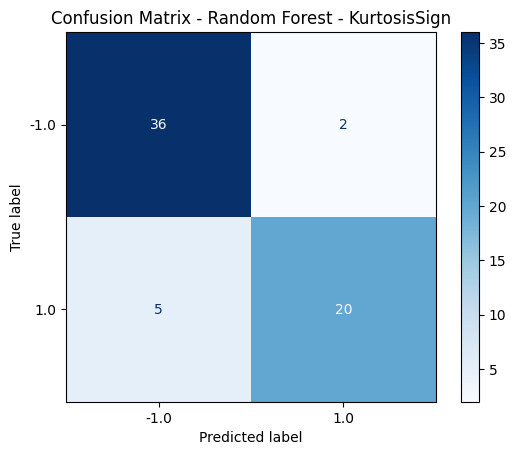

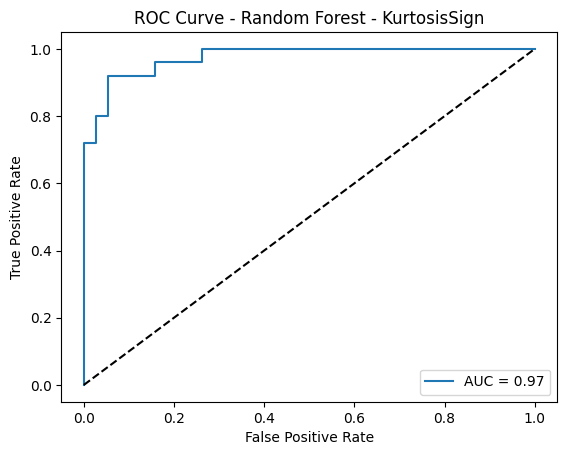

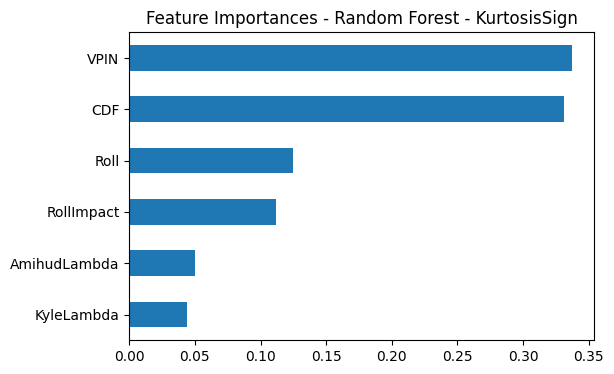

ReturnsSign


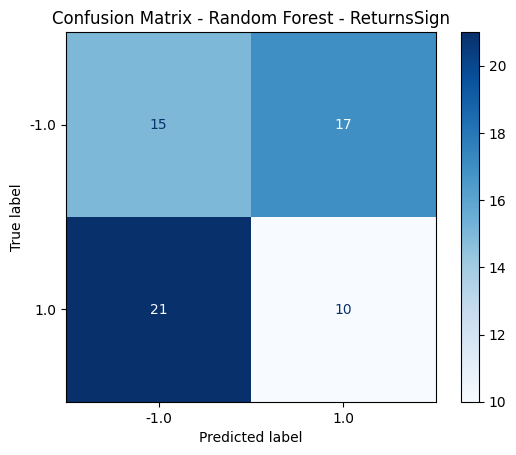

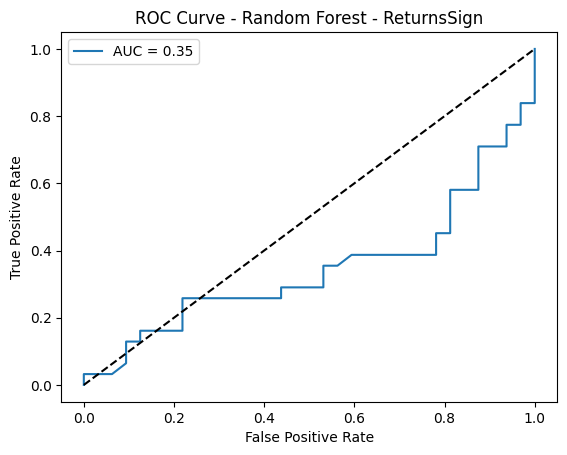

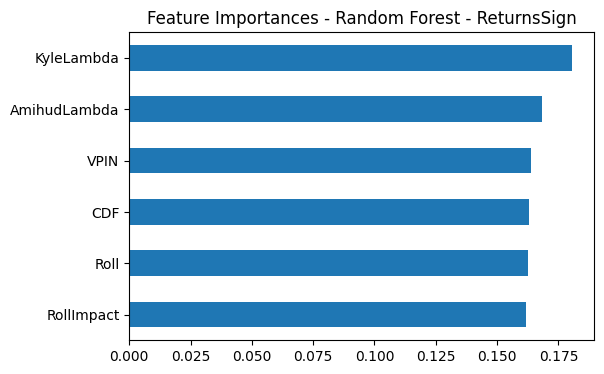

MASign


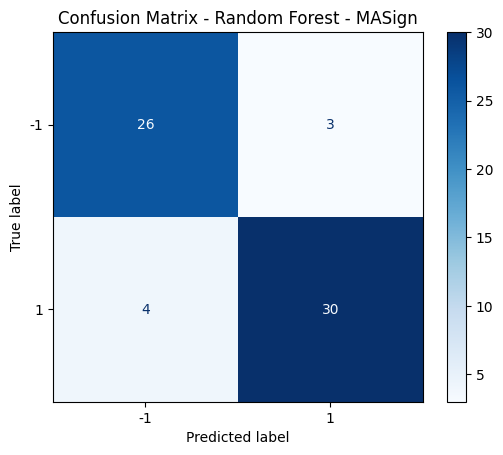

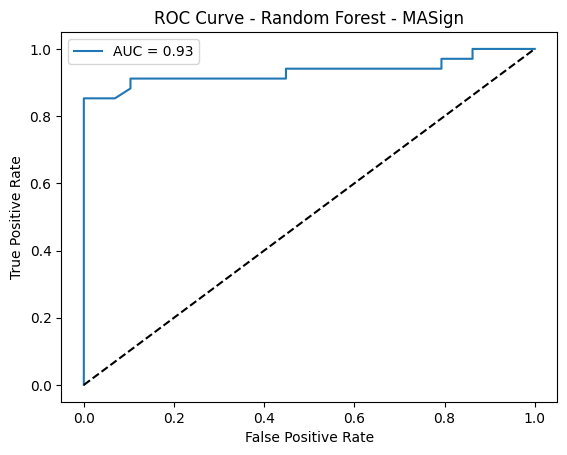

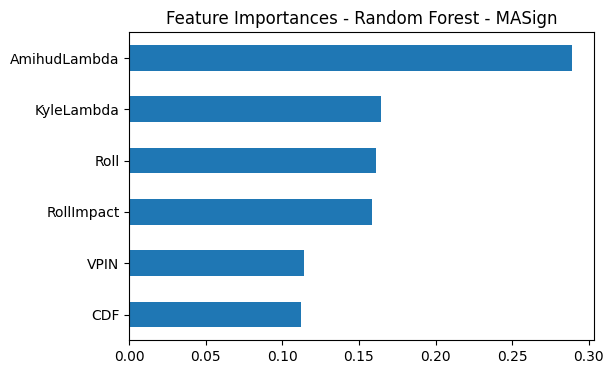

In [27]:
for col in target_cols:
    print(col)
    data_info = model_info[col]
    cm = confusion_matrix(data_info["y_test"], data_info["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_info["model"].classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Random Forest - {col}")
    plt.show()
    #########
    fpr, tpr, thresholds = roc_curve(data_info["y_test"], data_info["y_prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Random Forest - {col}")
    plt.legend()
    plt.show()
    importances =  data_info["model"].feature_importances_
    feat_importances = pd.Series(importances, index=X_train.columns)
    feat_importances.sort_values().plot(kind="barh", figsize=(6,4))
    plt.title(f"Feature Importances - Random Forest - {col}")
    plt.show()

In [28]:
acc_df = pd.DataFrame(index=target_cols, columns=train_cols)
model_info = {}
for col in list_output:
    for col_in in lst_input:
        train_cols = [col_in]
        X_train = train_data[col][train_cols]
        y_train = train_data[col][col]
        X_test = test_data[col][train_cols]
        y_test = test_data[col][col]

        model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

        model_info[col].fit(X_train, y_train)

        y_pred = model_info[col].predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        acc_df.loc[col, col_in] = f"{accuracy:.4f}"
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.5873
              precision    recall  f1-score   support

        -1.0       0.57      0.57      0.57        30
         1.0       0.61      0.61      0.61        33

    accuracy                           0.59        63
   macro avg       0.59      0.59      0.59        63
weighted avg       0.59      0.59      0.59        63

Độ chính xác của mô hình cho SpreadChangeSign: 0.4603
              precision    recall  f1-score   support

        -1.0       0.44      0.47      0.45        30
         1.0       0.48      0.45      0.47        33

    accuracy                           0.46        63
   macro avg       0.46      0.46      0.46        63
weighted avg       0.46      0.46      0.46        63

Độ chính xác của mô hình cho SpreadChangeSign: 0.4444
              precision    recall  f1-score   support

        -1.0       0.43      0.53      0.48        30
         1.0       0.46      0.36      0.41        33

    accuracy        

VPIN    Roll RollImpact KyleLambda AmihudLambda  \
SpreadChangeSign        0.5873  0.4603     0.4444     0.4921       0.4127   
RealizedVolatilitySign  0.6190  0.6349     0.6667     0.6032       0.9524   
JB_ChangeSign           0.8413  0.6508     0.6349     0.5397       0.6984   
AR_ChangeSign           0.8254  0.7302     0.6349     0.5397       0.6825   
SkewnessSign            0.5238  0.6667     0.6667     0.6032       0.6825   
KurtosisSign            0.8889  0.6984     0.6984     0.5873       0.5714   
ReturnsSign             0.5079  0.4603     0.4921     0.5714       0.5238   
MASign                  0.5873  0.7302     0.6667     0.6190       0.6032   

                           CDF  
SpreadChangeSign        0.5079  
RealizedVolatilitySign  0.5556  
JB_ChangeSign           0.8254  
AR_ChangeSign           0.8254  
SkewnessSign            0.5238  
KurtosisSign            0.8889  
ReturnsSign             0.4762  
MASign                  0.6825

### Mô hình XGBoost

In [29]:
# train_cols = ["VPIN"]
# for col in target_cols:
#         # Khởi tạo mô hình XGBoost
#     model = XGBClassifier(
#         n_estimators=100,
#         max_depth=3,
#         learning_rate=0.1,
#         # use_label_encoder=False,
#         eval_metric='logloss'
#     )
#     X_train = train_data[col][train_cols]
#     y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
#     X_test = test_data[col][train_cols]
#     y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

#     # Huấn luyện mô hình
#     model.fit(X_train, y_train)

#     # Dự đoán và đánh giá
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred)

#     print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
#     print(report)


In [30]:
# train_cols = lst_input
# for col in target_cols:
#         # Khởi tạo mô hình XGBoost
#     model = XGBClassifier(
#         n_estimators=100,
#         max_depth=3,
#         learning_rate=0.1,
#         # use_label_encoder=False,
#         eval_metric='logloss'
#     )
#     X_train = train_data[col][train_cols]
#     y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
#     X_test = test_data[col][train_cols]
#     y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

#     # Huấn luyện mô hình
#     model.fit(X_train, y_train)

#     # Dự đoán và đánh giá
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred)

#     print(f"Độ chính xác của mô hình: {accuracy:.4f}")
#     print(report)
